# F1 Project

## Imports

In [75]:
import os
import json
import fastf1
import requests
import pandas as pd
import numpy as np
from pathlib import Path
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

fastf1.set_log_level('WARNING')

## Folder Structure

In [2]:
project_path = r'D:\georgiatech_ms_qcf\courses\machine_learning_cs_7641\project\f1_ml_project'
raw_data_folder = 'raw_data'
clean_data_folder = 'clean_data'
output_folder = 'output'
bacinger_folder = 'f1-circuits-master'
tum_folder = 'racetrack-database-master'
fastf1_folder = 'fastf1_data'
raw_data_path = os.path.join(project_path, raw_data_folder)
clean_data_path = os.path.join(project_path, clean_data_folder)
output_path = os.path.join(project_path, output_folder)
bacinger_path = os.path.join(raw_data_path, bacinger_folder)
tum_path = os.path.join(raw_data_path, tum_folder)
fastf1_path = os.path.join(raw_data_path, fastf1_folder)

## Loading Data

### Bacinger Track Data

In [3]:
bac_dict = dict()
bac_files = ['f1-circuits', 'f1-locations']
for file in bac_files:
    geojson_path = Path(os.path.join(bacinger_path, f'{file}.geojson'))
    with geojson_path.open('r', encoding='utf-8') as f:
        bac_dict[file] = json.load(f)

In [4]:
bac_dict

{'f1-circuits': {'type': 'FeatureCollection',
  'name': 'f1-circuits',
  'bbox': [-115.173015, -37.853926, 144.97859, 52.391811],
  'features': [{'type': 'Feature',
    'properties': {'id': 'au-1953',
     'Location': 'Melbourne',
     'Name': 'Albert Park Circuit',
     'opened': 1953,
     'firstgp': 1996,
     'length': 5278,
     'altitude': 10},
    'bbox': [144.962138, -37.853926, 144.97859, -37.838005],
    'geometry': {'type': 'LineString',
     'coordinates': [[144.968644, -37.849757],
      [144.967627, -37.848964],
      [144.966121, -37.847751],
      [144.966034, -37.847681],
      [144.965997, -37.847585],
      [144.966003, -37.847543],
      [144.966028, -37.847504],
      [144.966079, -37.847406],
      [144.966164, -37.847287],
      [144.966217, -37.847135],
      [144.966247, -37.846948],
      [144.966253, -37.846811],
      [144.9662, -37.846544],
      [144.966134, -37.846408],
      [144.966031, -37.846266],
      [144.96591, -37.846152],
      [144.965642, -37.

### TUM Track Data

In [5]:
tum_dict = {'tracks': dict(), 'racelines': dict()}
f1_tracks = ['Austin', 'Budapest', 'Catalunya', 'Hockenheim', 'Melbourne', 'MexicoCity',
             'Montreal', 'Monza', 'Sakhir', 'SaoPaulo', 'Sepang', 'Shanghai', 'Silverstone',
             'Sochi', 'Spa', 'Spielberg', 'Suzuka', 'YasMarina', 'Zandvoort']
for folder in tum_dict.keys():
    temp_dict = dict()
    folder_path = os.path.join(tum_path, folder)
    files = os.listdir(folder_path)
    if folder == 'tracks':
        col_names = ['x_m', 'y_m', 'w_tr_right_m', 'w_tr_left_m']
    elif folder == 'racelines':
        col_names = ['x_m', 'y_m']
    for file in files:
        if 'csv' in file:
            if file.split('.')[0] in f1_tracks:
                filepath = os.path.join(folder_path, file)
                track_name = str.lower(file.split('.')[0])
                temp_dict[track_name] = pd.read_csv(filepath, index_col = False, header = 0, names = col_names)
    tum_dict[folder] = temp_dict

In [6]:
tum_dict['tracks']['zandvoort']

,x_m,y_m,w_tr_right_m,w_tr_left_m
0,-1.683339,-1.878198,5.074,5.271
1,0.151452,2.772507,5.099,5.295
2,1.986397,7.423128,5.125,5.319
3,3.821455,12.073677,5.150,5.343
4,5.656587,16.724166,5.175,5.367
...,...,...,...,...
859,-10.853581,-25.133415,4.948,5.151
860,-9.020162,-20.482105,4.973,5.175
861,-7.186388,-15.830941,4.998,5.199
862,-5.352300,-11.179909,5.024,5.223


z|### Fast F1 Driver Data

In [7]:
all_fastf1_data = dict()
years = os.listdir(fastf1_path)

for year in years:
    all_fastf1_data[year] = dict()
    year_path = os.path.join(fastf1_path, year)
    rounds = os.listdir(year_path)
    print(year)

    for r in rounds:
        print(r)
        if 'schedule' in r:
            sched_path = os.path.join(year_path, r)
            df_sched = pd.read_csv(sched_path, index_col=[0])
            all_fastf1_data[year]['schedule'] = df_sched
            continue

        all_fastf1_data[year][r] = dict()

        round_path = os.path.join(year_path, r)
        sessions = os.listdir(round_path)
        all_fastf1_data[year][r]['sessions'] = sessions

        for s in sessions:
            print(s)
            all_fastf1_data[year][r][s] = dict()

            sesh_path = os.path.join(round_path, s)
            files = os.listdir(sesh_path)
            all_fastf1_data[year][r][s]['telemetry_data'] = dict()

            lap_data_fname = f'lap_data_{year}_{r}_{s}.csv'
            lap_data_fpath = os.path.join(sesh_path, lap_data_fname)
            df_lap_data = pd.read_csv(lap_data_fpath, index_col=[0])
            all_fastf1_data[year][r][s]['lap_data'] = df_lap_data
            df_driver_map = df_lap_data[['DriverNumber', 'Driver']].set_index(['DriverNumber']).drop_duplicates()

            for f in files:
                print(f)
                if 'lap_data' in f:
                    continue

                fpath = os.path.join(sesh_path, f)
                df = pd.read_csv(fpath, index_col=[0])
                if df.empty:
                    continue
                driver_num = int(f.split('_')[-1].split('.')[0][6:])
                driver_name = df_driver_map.loc[driver_num, 'Driver']
                all_fastf1_data[year][r][s]['telemetry_data'][driver_name] = df


2022
round1
Q
lap_data_2022_round1_Q.csv
telemetry_data_2022_round1_Q_driver1.csv
telemetry_data_2022_round1_Q_driver10.csv
telemetry_data_2022_round1_Q_driver11.csv
telemetry_data_2022_round1_Q_driver14.csv
telemetry_data_2022_round1_Q_driver16.csv
telemetry_data_2022_round1_Q_driver18.csv
telemetry_data_2022_round1_Q_driver20.csv
telemetry_data_2022_round1_Q_driver22.csv
telemetry_data_2022_round1_Q_driver23.csv
telemetry_data_2022_round1_Q_driver24.csv
telemetry_data_2022_round1_Q_driver27.csv
telemetry_data_2022_round1_Q_driver3.csv
telemetry_data_2022_round1_Q_driver31.csv
telemetry_data_2022_round1_Q_driver4.csv
telemetry_data_2022_round1_Q_driver44.csv
telemetry_data_2022_round1_Q_driver47.csv
telemetry_data_2022_round1_Q_driver55.csv
telemetry_data_2022_round1_Q_driver6.csv
telemetry_data_2022_round1_Q_driver63.csv
telemetry_data_2022_round1_Q_driver77.csv
R
lap_data_2022_round1_R.csv
telemetry_data_2022_round1_R_driver1.csv
telemetry_data_2022_round1_R_driver10.csv
telemetry_d

In [8]:
# Check if data loaded properly
print(all_fastf1_data.keys())
print(all_fastf1_data['2022'].keys())
print(all_fastf1_data['2023']['round3'].keys())
print(all_fastf1_data['2024']['round10']['sessions'])
print(all_fastf1_data['2024']['round10']['Q']['telemetry_data'].keys())
print('\n')
print(all_fastf1_data['2024']['round10']['Q']['lap_data'].head())
print('\n')
print(all_fastf1_data['2024']['round10']['Q']['telemetry_data']['HAM'].head())
print('\n')
print(all_fastf1_data['2023']['schedule'].head())

dict_keys(['2022', '2023', '2024', '2025'])
dict_keys(['round1', 'round10', 'round11', 'round12', 'round13', 'round14', 'round15', 'round16', 'round17', 'round18', 'round19', 'round2', 'round20', 'round21', 'round22', 'round3', 'round4', 'round5', 'round6', 'round7', 'round8', 'round9', 'schedule'])
dict_keys(['sessions', 'Q', 'R'])
['Q', 'R']
dict_keys(['VER', 'GAS', 'PER', 'ALO', 'LEC', 'SAR', 'MAG', 'TSU', 'ALB', 'ZHO', 'HUL', 'RIC', 'OCO', 'NOR', 'HAM', 'SAI', 'RUS', 'BOT', 'PIA'])


                     Time Driver  DriverNumber                 LapTime  \
0  0 days 00:20:31.873000    NOR             4                     NaN   
1  0 days 00:21:44.259000    NOR             4  0 days 00:01:12.386000   
2  0 days 00:23:24.351000    NOR             4  0 days 00:01:40.092000   
3  0 days 00:45:41.347000    NOR             4                     NaN   
4  0 days 00:46:53.219000    NOR             4  0 days 00:01:11.872000   

   LapNumber  Stint              PitOutTime               PitI

### Track Mapping

In [9]:
track_map_fpath = os.path.join(raw_data_path, 'track_name_mapping.xlsx')
df_track_names_map = pd.read_excel(track_map_fpath)
df_track_names_map = df_track_names_map[['bacinger', 'fastf1', 'track_identifier']]
df_track_names_map.head()

,bacinger,fastf1,track_identifier
0,Austin,Austin,austin
1,Baku,Baku,baku
2,Barcelona,Barcelona,barcelona
3,Budapest,Budapest,budapest
4,Imola,Imola,imola


## Cleaning and Standardizing Data

### Bacinger Track Data

In [10]:
df_track_prop = df_track_names_map.copy()
df_track_prop.drop(columns=['fastf1'], inplace=True)
df_track_prop.set_index(['bacinger'], inplace=True)
df_track_prop.head()

,track_identifier
bacinger,
Austin,austin
Baku,baku
Barcelona,barcelona
Budapest,budapest
Imola,imola


In [11]:
bac_track_coords = dict()

for d in bac_dict['f1-circuits']['features']:

    d_temp = d["properties"]
    track = d_temp['Location']

    if track not in df_track_prop.index:
        continue

    length = d_temp['length']
    altitude = d_temp['altitude']

    track_id = df_track_prop.loc[track, 'track_identifier']
    df_track_prop.loc[track, 'length'] = length
    df_track_prop.loc[track, 'altitude'] = altitude

    coords = d['geometry']['coordinates']
    df_coords = pd.DataFrame(coords, columns=['x', 'y'])

    bac_track_coords[track_id] = df_coords

In [12]:
df_track_prop.set_index(['track_identifier'], inplace=True)

In [13]:
df_track_prop.head()

,length,altitude
track_identifier,,
austin,5514.0,130.0
baku,6003.0,-25.0
barcelona,4655.0,165.0
budapest,4381.0,239.0
imola,4909.0,47.0


In [14]:
bac_track_coords['melbourne'].head()

,x,y
0,144.968644,-37.849757
1,144.967627,-37.848964
2,144.966121,-37.847751
3,144.966034,-37.847681
4,144.965997,-37.847585


### FastF1 Data

In [15]:
df_tmap = df_track_names_map.copy()
df_tmap.drop(columns=['bacinger'], inplace=True)
df_tmap.set_index(['fastf1'], inplace=True)
df_tmap.index.name = 'Location'
df_tmap

,track_identifier
Location,
Austin,austin
Baku,baku
Barcelona,barcelona
Budapest,budapest
Imola,imola
Jeddah,jeddah
Las Vegas,las_vegas
Le Castellet,le_castellet
Lusail,lusail


In [67]:
driver_telemetry = dict()

# year, round, session, track_identifier, driver
# concat all driver data

for year in all_fastf1_data.keys():

    print(year)
    df_sched = all_fastf1_data[year]['schedule'].copy()
    df_sched = df_sched.set_index('Location').join(df_tmap, how='left').reset_index()
    df_sched.set_index('RoundNumber', inplace=True)
    # print(df_sched)

    for r in all_fastf1_data[year].keys():
        if 'schedule' in r:
            continue
        print(r)
        for sesh in all_fastf1_data[year][r].keys():
            if 'sessions' in sesh:
                continue
            print(sesh)
            for d in all_fastf1_data[year][r][sesh]['telemetry_data'].keys():
                print(d)
                if d not in driver_telemetry.keys():
                    driver_telemetry[d] = list()

                df_tele = all_fastf1_data[year][r][sesh]['telemetry_data'][d]
                df_tele['year'] = int(year)
                df_tele['round'] = int(r[5:])
                df_tele['session'] = sesh

                track_loc = df_sched.loc[df_tele['round'], 'Location'].iloc[0]
                track_id = df_tmap.loc[track_loc, 'track_identifier']

                df_tele['track_identifier'] = track_id
                df_tele['driver'] = d
                df_tele['lap_id'] = f'{year}_{r}_{sesh}_{track_id}'
                df_tele['driver_lap_id'] = f'{d}_{year}_{r}_{sesh}_{track_id}'
                driver_telemetry[d].append(df_tele)

for key, item in driver_telemetry.items():
    driver_telemetry[key] = pd.concat(item, ignore_index=True)

2022
round1
Q
VER
GAS
ALO
LEC
STR
MAG
TSU
ALB
ZHO
HUL
RIC
OCO
NOR
HAM
MSC
SAI
LAT
RUS
BOT
R
VER
GAS
PER
ALO
LEC
STR
MAG
TSU
ALB
ZHO
HUL
RIC
OCO
NOR
HAM
MSC
SAI
LAT
RUS
BOT
round10
Q
VER
GAS
PER
ALO
LEC
STR
MAG
TSU
ALB
ZHO
RIC
OCO
NOR
HAM
MSC
VET
SAI
LAT
RUS
BOT
R
VER
GAS
PER
ALO
LEC
STR
MAG
TSU
RIC
OCO
NOR
HAM
MSC
VET
SAI
LAT
BOT
round11
Q
VER
GAS
PER
ALO
LEC
STR
MAG
TSU
ALB
ZHO
RIC
OCO
NOR
HAM
MSC
VET
SAI
LAT
RUS
BOT
R
VER
GAS
PER
ALO
LEC
STR
MAG
TSU
ALB
ZHO
RIC
OCO
NOR
HAM
MSC
VET
SAI
LAT
RUS
BOT
S
VER
GAS
PER
LEC
STR
MAG
TSU
ALB
ZHO
RIC
OCO
NOR
HAM
MSC
VET
SAI
LAT
RUS
BOT
round12
Q
VER
GAS
PER
ALO
LEC
STR
MAG
TSU
ALB
ZHO
RIC
OCO
NOR
HAM
MSC
VET
SAI
LAT
RUS
BOT
R
VER
GAS
PER
ALO
LEC
STR
MAG
TSU
ALB
ZHO
RIC
OCO
NOR
HAM
MSC
VET
SAI
LAT
RUS
BOT
round13
Q
VER
GAS
PER
ALO
LEC
STR
MAG
TSU
ALB
ZHO
RIC
OCO
NOR
HAM
MSC
VET
SAI
LAT
RUS
BOT
R
VER
GAS
PER
ALO
LEC
STR
MAG
TSU
ALB
ZHO
RIC
OCO
NOR
HAM
MSC
VET
SAI
LAT
RUS
BOT
round14
Q
VER
GAS
PER
ALO
LEC
STR
MAG
TSU
ALB
ZHO
RIC
OCO
NOR
HAM
MSC
VET


In [68]:
driver_telemetry['HAM'].head()

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,...,X,Y,Z,year,round,session,track_identifier,driver,lap_id,driver_lap_id
0,2022-03-19 15:39:03.785,0 days 00:54:02.856000,NaN,387.923056,0 days 00:00:00,10755.462410,290.587498,8,100.0,False,...,-379.526377,1298.474152,-158.888808,2022,1,Q,sakhir,HAM,2022_round1_Q_sakhir,HAM_2022_round1_Q_sakhir
1,2022-03-19 15:39:03.807,0 days 00:54:02.878000,NaN,387.923056,0 days 00:00:00.022000,10771.000000,291.000000,8,100.0,False,...,-378.671076,1316.250175,-158.955030,2022,1,Q,sakhir,HAM,2022_round1_Q_sakhir,HAM_2022_round1_Q_sakhir
2,2022-03-19 15:39:03.824,0 days 00:54:02.895000,NaN,387.923056,0 days 00:00:00.039000,10771.910711,291.121428,8,100.0,False,...,-378.000000,1330.000000,-159.000000,2022,1,Q,sakhir,HAM,2022_round1_Q_sakhir,HAM_2022_round1_Q_sakhir
3,2022-03-19 15:39:04.044,0 days 00:54:03.115000,NaN,387.923056,0 days 00:00:00.259000,10783.696425,292.692857,8,100.0,False,...,-369.000000,1509.000000,-159.000000,2022,1,Q,sakhir,HAM,2022_round1_Q_sakhir,HAM_2022_round1_Q_sakhir
4,2022-03-19 15:39:04.087,0 days 00:54:03.158000,63.0,387.923056,0 days 00:00:00.302000,10786.000000,293.000000,8,100.0,False,...,-367.425142,1544.197337,-158.824720,2022,1,Q,sakhir,HAM,2022_round1_Q_sakhir,HAM_2022_round1_Q_sakhir


In [18]:
driver_telemetry['HAM'].columns

Index(['Date', 'SessionTime', 'DriverAhead', 'DistanceToDriverAhead', 'Time',
       'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Source',
       'Distance', 'RelativeDistance', 'Status', 'X', 'Y', 'Z', 'year',
       'round', 'session', 'track_identifier', 'driver'],
      dtype='object')

## Circuit Plots

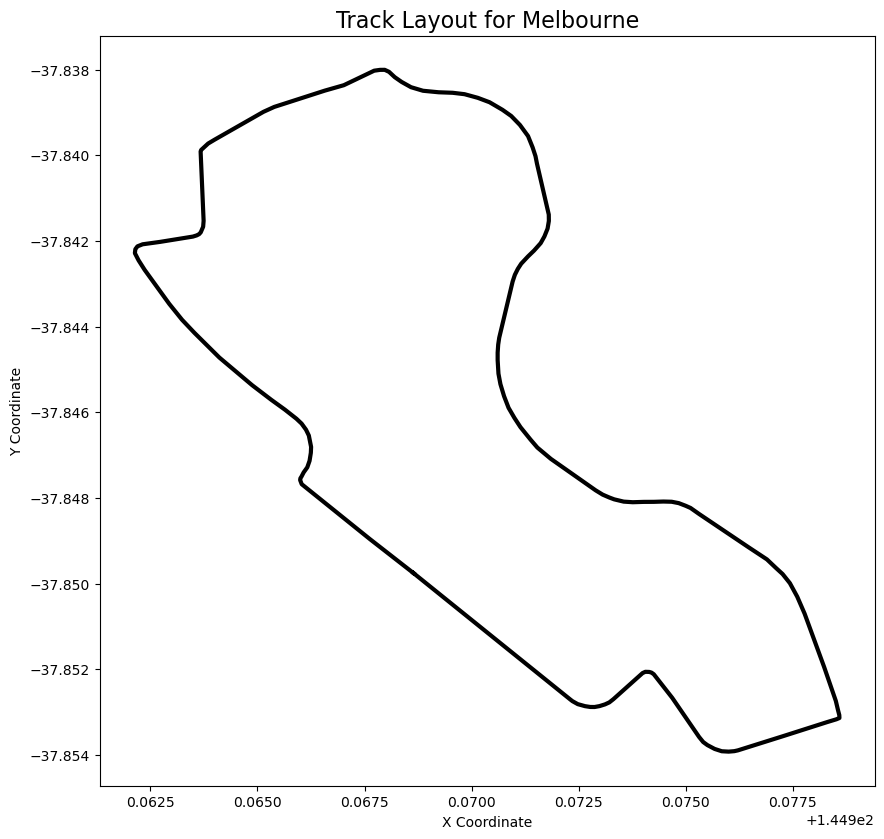

In [19]:
# # Replicating your data structure for a runnable example
# # You would load your actual 'bac_track_coords' data here
# t = np.linspace(0, 2 * np.pi, 1000)
# x_coords = 10 * np.cos(t) + np.cos(5 * t)
# y_coords = 10 * np.sin(t) + np.sin(5 * t)
# bac_track_coords = {
#     'melbourne': pd.DataFrame({'x': x_coords, 'y': y_coords})
# }

# Select the track to plot
track_name = 'melbourne'
track_data = bac_track_coords[track_name]

# Create the plot
plt.figure(figsize=(10, 10))
plt.plot(track_data['x'], track_data['y'], color='black', linewidth=3)

# Ensure the aspect ratio is equal to prevent distortion
plt.gca().set_aspect('equal', adjustable='box')

# Add titles and labels
plt.title(f'Track Layout for {track_name.capitalize()}', fontsize=16)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(False) # Hide grid lines for a cleaner look
plt.show()


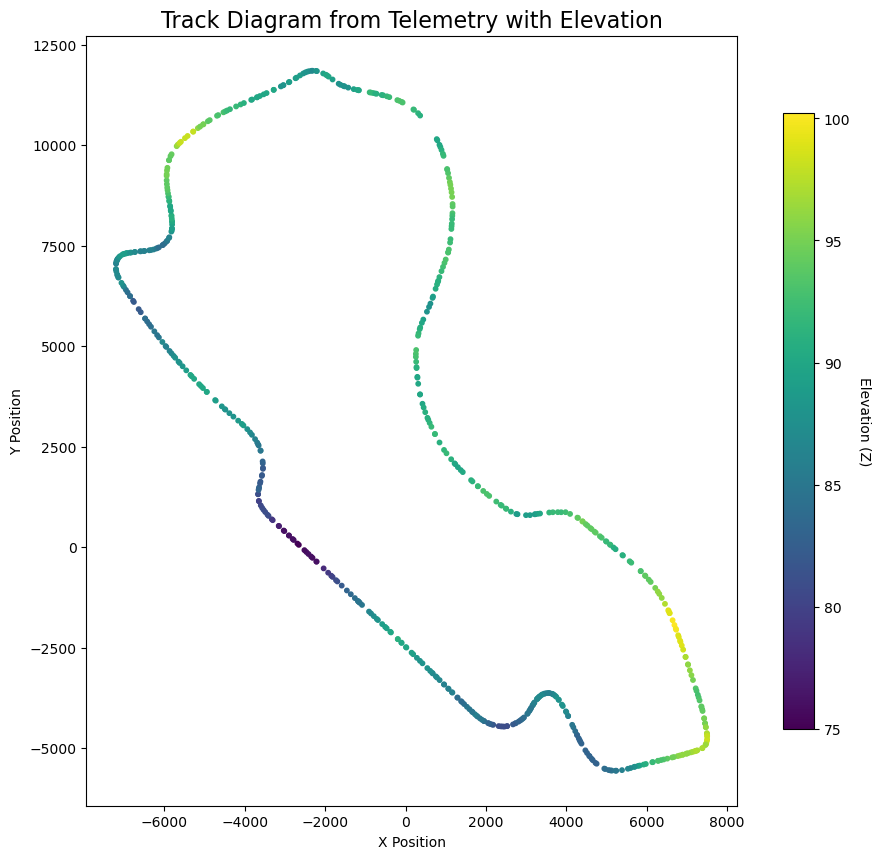

In [20]:
df_driver_telemetry = driver_telemetry['HAM']
df_driver_telemetry = df_driver_telemetry.loc[(df_driver_telemetry['year'] == 2022) &
                                              (df_driver_telemetry['track_identifier'] == 'melbourne') &
                                              (df_driver_telemetry['session'] == 'R')]

# Create the plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    df_driver_telemetry['X'],
    df_driver_telemetry['Y'],
    c=df_driver_telemetry['Z'], # Use Z-coordinate for color
    cmap='viridis', # Choose a color map
    s=10 # Set marker size
)

# Ensure the aspect ratio is equal
plt.gca().set_aspect('equal', adjustable='box')

# Add a color bar to show the elevation scale
cbar = plt.colorbar(scatter, shrink=0.8)
cbar.set_label('Elevation (Z)', rotation=270, labelpad=15)

# Add titles and labels
plt.title('Track Diagram from Telemetry with Elevation', fontsize=16)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(False)
plt.show()

## Feature Engineering

In [21]:
# Adding elevation to df_track_prop
df_driver_telemetry = driver_telemetry['HAM']

df_track_prop['elevation_change'] = np.nan

df_na = df_track_prop.copy()
year = 2022
for year in [2022, 2023, 2024, 2025]:
    for track in df_na.index:
        # print(track)
        df_xyz = df_driver_telemetry.loc[(df_driver_telemetry['year'] == year) &
                                          (df_driver_telemetry['track_identifier'] == track) &
                                          (df_driver_telemetry['session'] == 'R')]
        ele_change = df_xyz['Z'].max() - df_xyz['Z'].min()
        df_track_prop.loc[track, 'elevation_change'] = ele_change

    df_na = df_track_prop[df_track_prop['elevation_change'].isna()]


In [22]:
df_track_prop.head()

,length,altitude,elevation_change
track_identifier,,,
austin,5514.0,130.0,303.321949
baku,6003.0,-25.0,268.048448
barcelona,4655.0,165.0,300.623438
budapest,4381.0,239.0,348.143399
imola,4909.0,47.0,344.607980


In [23]:
# df_track_prop['n_turns'] = np.nan
#
# def count_turns_with_clustering(track_coords_df, track_name, output_path, angle_threshold_deg=10, eps=1.0, min_samples=3, visualize=False):
#     """
#     Calculates the number of turns and evaluates the clustering quality.
#
#     Args:
#         track_coords_df (pd.DataFrame): DataFrame with 'x' and 'y' columns.
#         track_name (str): The name of the track, used for saving files.
#         output_path (str): Directory path to save visualization images.
#         angle_threshold_deg (int): The angle to identify points that are part of a corner.
#         eps (float): The maximum distance for DBSCAN.
#         min_samples (int): The number of samples for a DBSCAN core point.
#         visualize (bool): If True, plots and saves the cluster visualization.
#
#     Returns:
#         dict: A dictionary containing the number of turns and evaluation scores.
#     """
#     x = track_coords_df['x'].values
#     y = track_coords_df['y'].values
#     angles = []
#
#     for i in range(1, len(x) - 1):
#         vec1 = (x[i] - x[i-1], y[i] - y[i-1])
#         vec2 = (x[i+1] - x[i], y[i+1] - y[i])
#         dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]
#         mag1 = np.sqrt(vec1[0]**2 + vec1[1]**2)
#         mag2 = np.sqrt(vec2[0]**2 + vec2[1]**2)
#
#         if mag1 == 0 or mag2 == 0:
#             angles.append(0)
#             continue
#
#         cos_angle = np.clip(dot_product / (mag1 * mag2), -1.0, 1.0)
#         angle_rad = np.arccos(cos_angle)
#         angles.append(np.degrees(angle_rad))
#
#     corner_points = pd.DataFrame({'x': x[1:-1], 'y': y[1:-1], 'angle': angles})
#     high_curvature_points = corner_points[corner_points['angle'] > angle_threshold_deg]
#
#     # Initialize metrics to NaN
#     silhouette = np.nan
#     calinski = np.nan
#     davies = np.nan
#     n_clusters = 0
#
#     # Clustering and metrics calculation require a minimum number of points
#     if len(high_curvature_points) >= min_samples:
#         db = DBSCAN(eps=eps, min_samples=min_samples).fit(high_curvature_points[['x', 'y']])
#         labels = db.labels_
#         n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#
#         # Evaluation metrics can only be computed if there is more than 1 cluster
#         if n_clusters > 1:
#             silhouette = silhouette_score(high_curvature_points[['x', 'y']], labels)
#             calinski = calinski_harabasz_score(high_curvature_points[['x', 'y']], labels)
#             davies = davies_bouldin_score(high_curvature_points[['x', 'y']], labels)
#
#     if visualize:
#         plt.figure(figsize=(12, 12))
#         plt.plot(x, y, color='grey', linestyle='--', label='Full Track')
#         if len(high_curvature_points) > 0:
#             plt.scatter(high_curvature_points['x'], high_curvature_points['y'], c=labels, cmap='viridis', s=50, label='Corner Clusters')
#         plt.title(f'Turn Detection via Clustering (Found {n_clusters} turns) for {track_name.capitalize()}')
#         plt.xlabel('X Coordinate')
#         plt.ylabel('Y Coordinate')
#         plt.gca().set_aspect('equal', adjustable='box')
#         plt.legend()
#
#         img_filename = f'corner_clusters_{track_name}.png'
#         img_fpath = os.path.join(output_path, img_filename)
#         plt.savefig(img_fpath, dpi=300, bbox_inches='tight')
#         plt.close() # Close the plot to avoid displaying it in a loop
#
#     return {
#         'Turns': n_clusters,
#         'Silhouette Score': silhouette,
#         'Calinski-Harabasz Score': calinski,
#         'Davies-Bouldin Score': davies
#     }
#
# # Define an output path for images and create it if it doesn't exist
#
# # --- Method 2: Clustering with DBSCAN ---
# print("--- Clustering (DBSCAN) to find number of turns ---")
# all_results = []
#
# for track_name, track_data in bac_track_coords.items():
#     # These parameters might need to be tuned per track for best results
#     result = count_turns_with_clustering(
#         track_data,
#         track_name,
#         output_path,
#         angle_threshold_deg=1,
#         eps=0.00035,
#         min_samples=2,
#         visualize=True
#     )
#
#     df_track_prop.loc[track_name, 'n_turns'] = result['Turns']
#     result['Track'] = track_name.capitalize()
#     all_results.append(result)
#     print(f"Processed '{track_name.capitalize()}'...")
#
# # --- Display Results ---
# print("\n" + "="*80)
# print("                       DETAILED CLUSTERING EVALUATION")
# print("="*80)
# results_df = pd.DataFrame(all_results).set_index('Track')
# # Reorder columns for better presentation
# results_df = results_df[['Turns', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score']]
# print(results_df.to_string(float_format="%.4f"))
# print("="*80)
#
# print("\n" + "="*80)
# print("                       AGGREGATE METRIC SCORES (AVERAGE)")
# print("="*80)
# # Calculate the mean, ignoring tracks where metrics couldn't be calculated (NaNs)
# aggregate_metrics = results_df[['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score']].mean().to_frame('Average Score')
# print(aggregate_metrics.to_string(float_format="%.4f"))
# print("="*80)
# print(f"\nVisualizations saved to '{output_path}' directory.")


--- Clustering (DBSCAN) to find number of turns ---
Processed 'Melbourne'...
Processed 'Sakhir'...
Processed 'Shanghai'...
Processed 'Baku'...
Processed 'Barcelona'...
Processed 'Monaco'...
Processed 'Montreal'...
Processed 'Le_castellet'...
Processed 'Spielberg'...
Processed 'Silverstone'...
Processed 'Budapest'...
Processed 'Spa'...
Processed 'Monza'...
Processed 'Singapore'...
Processed 'Suzuka'...
Processed 'Austin'...
Processed 'Mexico_city'...
Processed 'Sao_paulo'...
Processed 'Yas_marina'...
Processed 'Imola'...
Processed 'Zandvoort'...
Processed 'Jeddah'...
Processed 'Miami'...
Processed 'Lusail'...
Processed 'Las_vegas'...

                       DETAILED CLUSTERING EVALUATION
              Turns  Silhouette Score  Calinski-Harabasz Score  Davies-Bouldin Score
Track                                                                               
Melbourne        17            0.5303                  42.9498                1.5680
Sakhir           15            0.6470            

In [24]:
# df_track_prop

,length,altitude,elevation_change,n_turns
track_identifier,,,,
austin,5514.0,130.0,303.321949,15.0
baku,6003.0,-25.0,268.048448,15.0
barcelona,4655.0,165.0,300.623438,11.0
budapest,4381.0,239.0,348.143399,16.0
imola,4909.0,47.0,344.607980,16.0
jeddah,6175.0,12.0,24.130073,23.0
las_vegas,6116.0,610.0,163.010678,9.0
le_castellet,5842.0,408.0,302.220624,15.0
lusail,5380.0,5.0,42.121258,13.0


In [25]:
# bac_track_coords['melbourne']

,x,y
0,144.968644,-37.849757
1,144.967627,-37.848964
2,144.966121,-37.847751
3,144.966034,-37.847681
4,144.965997,-37.847585
...,...,...
141,144.972649,-37.852864
142,144.972480,-37.852817
143,144.972355,-37.852747
144,144.972306,-37.852709


In [40]:
# Adding elevation to df_track_prop
fastf1_track_coords = dict()

df_driver_telemetry = driver_telemetry['HAM']

year = 2022
diff = list(set(df_track_prop.index).difference(set(fastf1_track_coords.keys())))
diff.sort()
for year in [2022, 2023, 2024, 2025]:

    for track in diff:
        # print(track)
        df_xyz = df_driver_telemetry.loc[(df_driver_telemetry['year'] == year) &
                                          (df_driver_telemetry['track_identifier'] == track) &
                                          (df_driver_telemetry['session'] == 'R')]
        df_xyz = df_xyz[['X', 'Y', 'Z']]
        if not df_xyz.empty:
            fastf1_track_coords[track] = df_xyz

    diff = list(set(df_track_prop.index).difference(set(fastf1_track_coords.keys())))
    diff.sort()
    print(diff)

['las_vegas', 'lusail', 'shanghai', 'spa']
['lusail', 'shanghai']
[]
[]


In [42]:
fastf1_track_coords['las_vegas']

,X,Y,Z
53058,1992.442004,-707.781585,6064.996429
53059,2016.000000,-680.000000,6065.000000
53060,2129.830348,-545.244698,6065.012931
53061,2164.000000,-505.000000,6065.000000
53062,2260.904800,-392.307332,6064.872321
...,...,...,...
53787,1680.142560,-1049.225336,6065.740452
53788,1730.000000,-1005.000000,6065.000000
53789,1902.811209,-818.136270,6064.707319
53790,1954.000000,-755.000000,6065.000000


In [57]:
df_track_prop['n_turns'] = np.nan

def count_turns_with_clustering(track_coords_df, track_name, output_path, angle_threshold_deg=10, eps=1.0, min_samples=3, visualize=False):
    """
    Calculates the number of turns and evaluates the clustering quality.

    Args:
        track_coords_df (pd.DataFrame): DataFrame with 'x' and 'y' columns.
        track_name (str): The name of the track, used for saving files.
        output_path (str): Directory path to save visualization images.
        angle_threshold_deg (int): The angle to identify points that are part of a corner.
        eps (float): The maximum distance for DBSCAN.
        min_samples (int): The number of samples for a DBSCAN core point.
        visualize (bool): If True, plots and saves the cluster visualization.

    Returns:
        dict: A dictionary containing the number of turns and evaluation scores.
    """
    x = track_coords_df['X'].values
    y = track_coords_df['Y'].values
    angles = []

    for i in range(1, len(x) - 1):
        vec1 = (x[i] - x[i-1], y[i] - y[i-1])
        vec2 = (x[i+1] - x[i], y[i+1] - y[i])
        dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]
        mag1 = np.sqrt(vec1[0]**2 + vec1[1]**2)
        mag2 = np.sqrt(vec2[0]**2 + vec2[1]**2)

        if mag1 == 0 or mag2 == 0:
            angles.append(0)
            continue

        cos_angle = np.clip(dot_product / (mag1 * mag2), -1.0, 1.0)
        angle_rad = np.arccos(cos_angle)
        angles.append(np.degrees(angle_rad))

    corner_points = pd.DataFrame({'x': x[1:-1], 'y': y[1:-1], 'angle': angles})
    high_curvature_points = corner_points[corner_points['angle'] > angle_threshold_deg]

    # Initialize metrics to NaN
    silhouette = np.nan
    calinski = np.nan
    davies = np.nan
    n_clusters = 0

    # Clustering and metrics calculation require a minimum number of points
    if len(high_curvature_points) >= min_samples:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(high_curvature_points[['x', 'y']])
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Evaluation metrics can only be computed if there is more than 1 cluster
        if n_clusters > 1:
            silhouette = silhouette_score(high_curvature_points[['x', 'y']], labels)
            calinski = calinski_harabasz_score(high_curvature_points[['x', 'y']], labels)
            davies = davies_bouldin_score(high_curvature_points[['x', 'y']], labels)

    if visualize:
        plt.figure(figsize=(12, 12))
        plt.plot(x, y, color='grey', linestyle='--', label='Full Track')
        if len(high_curvature_points) > 0:
            plt.scatter(high_curvature_points['x'], high_curvature_points['y'], c=labels, cmap='viridis', s=50, label='Corner Clusters')
        plt.title(f'Turn Detection via Clustering (Found {n_clusters} turns) for {track_name.capitalize()}')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()

        img_filename = f'corner_clusters_{track_name}.png'
        img_fpath = os.path.join(output_path, img_filename)
        plt.savefig(img_fpath, dpi=300, bbox_inches='tight')
        plt.close() # Close the plot to avoid displaying it in a loop

    return {
        'Turns': n_clusters,
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Score': calinski,
        'Davies-Bouldin Score': davies
    }

# Define an output path for images and create it if it doesn't exist

# --- Method 2: Clustering with DBSCAN ---
print("--- Clustering (DBSCAN) to find number of turns ---")
all_results = []

for track_name, track_data in fastf1_track_coords.items():
    # These parameters might need to be tuned per track for best results
    result = count_turns_with_clustering(
        track_data,
        track_name,
        output_path,
        angle_threshold_deg=1,
        eps=220,
        min_samples=5,
        visualize=True
    )

    df_track_prop.loc[track_name, 'n_turns'] = result['Turns']
    result['Track'] = track_name.capitalize()
    all_results.append(result)
    print(f"Processed '{track_name.capitalize()}'...")

# --- Display Results ---
print("\n" + "="*80)
print("                       DETAILED CLUSTERING EVALUATION")
print("="*80)
results_df = pd.DataFrame(all_results).set_index('Track')
# Reorder columns for better presentation
results_df = results_df[['Turns', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score']]
print(results_df.to_string(float_format="%.4f"))
print("="*80)

print("\n" + "="*80)
print("                       AGGREGATE METRIC SCORES (AVERAGE)")
print("="*80)
# Calculate the mean, ignoring tracks where metrics couldn't be calculated (NaNs)
aggregate_metrics = results_df[['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score']].mean().to_frame('Average Score')
print(aggregate_metrics.to_string(float_format="%.4f"))
print("="*80)
print(f"\nVisualizations saved to '{output_path}' directory.")


--- Clustering (DBSCAN) to find number of turns ---
Processed 'Austin'...
Processed 'Baku'...
Processed 'Barcelona'...
Processed 'Budapest'...
Processed 'Imola'...
Processed 'Jeddah'...
Processed 'Le_castellet'...
Processed 'Melbourne'...
Processed 'Mexico_city'...
Processed 'Miami'...
Processed 'Monaco'...
Processed 'Montreal'...
Processed 'Monza'...
Processed 'Sakhir'...
Processed 'Sao_paulo'...
Processed 'Silverstone'...
Processed 'Singapore'...
Processed 'Spielberg'...
Processed 'Suzuka'...
Processed 'Yas_marina'...
Processed 'Zandvoort'...
Processed 'Las_vegas'...
Processed 'Spa'...
Processed 'Lusail'...
Processed 'Shanghai'...

                       DETAILED CLUSTERING EVALUATION
              Turns  Silhouette Score  Calinski-Harabasz Score  Davies-Bouldin Score
Track                                                                               
Austin           20            0.4199                 112.3305                2.1559
Baku             14            0.4005            

In [58]:
df_track_prop

,length,altitude,elevation_change,n_turns
track_identifier,,,,
austin,5514.0,130.0,303.321949,20.0
baku,6003.0,-25.0,268.048448,14.0
barcelona,4655.0,165.0,300.623438,15.0
budapest,4381.0,239.0,348.143399,13.0
imola,4909.0,47.0,344.607980,12.0
jeddah,6175.0,12.0,24.130073,22.0
las_vegas,6116.0,610.0,163.010678,13.0
le_castellet,5842.0,408.0,302.220624,14.0
lusail,5380.0,5.0,42.121258,20.0


## Driver Clustering

In [125]:
temp_list = list()
for driver, tele in driver_telemetry.items():
    temp_list.append(tele)

df_all_telemetry = pd.concat(temp_list, ignore_index=True)

In [126]:
df_all_telemetry.head()

,Date,SessionTime,DriverAhead,DistanceToDriverAhead,Time,RPM,Speed,nGear,Throttle,Brake,...,X,Y,Z,year,round,session,track_identifier,driver,lap_id,driver_lap_id
0,2022-03-19 15:58:45.862,0 days 01:13:44.933000,NaN,876.661111,0 days 00:00:00,10860.708178,293.233334,7,100.0,False,...,-381.311667,1266.416781,-159.000004,2022,1,Q,sakhir,VER,2022_round1_Q_sakhir,VER_2022_round1_Q_sakhir
1,2022-03-19 15:58:45.931,0 days 01:13:45.002000,NaN,876.661111,0 days 00:00:00.069000,10693.000000,294.000000,7,100.0,False,...,-378.565537,1325.358681,-159.000003,2022,1,Q,sakhir,VER,2022_round1_Q_sakhir,VER_2022_round1_Q_sakhir
2,2022-03-19 15:58:45.963,0 days 01:13:45.034000,NaN,876.661111,0 days 00:00:00.101000,10657.960000,294.160000,7,100.0,False,...,-377.000000,1358.000000,-159.000000,2022,1,Q,sakhir,VER,2022_round1_Q_sakhir,VER_2022_round1_Q_sakhir
3,2022-03-19 15:58:46.131,0 days 01:13:45.202000,14.0,876.661111,0 days 00:00:00.269000,10474.000000,295.000000,8,100.0,False,...,-365.962175,1580.516163,-158.999965,2022,1,Q,sakhir,VER,2022_round1_Q_sakhir,VER_2022_round1_Q_sakhir
4,2022-03-19 15:58:46.243,0 days 01:13:45.314000,14.0,873.861111,0 days 00:00:00.381000,10583.200000,295.700000,8,100.0,False,...,-360.000000,1702.000000,-159.000000,2022,1,Q,sakhir,VER,2022_round1_Q_sakhir,VER_2022_round1_Q_sakhir


In [127]:
df_all_telemetry.columns

Index(['Date', 'SessionTime', 'DriverAhead', 'DistanceToDriverAhead', 'Time',
       'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Source',
       'Distance', 'RelativeDistance', 'Status', 'X', 'Y', 'Z', 'year',
       'round', 'session', 'track_identifier', 'driver', 'lap_id',
       'driver_lap_id'],
      dtype='object')

### Phase 1: High-Level Profiling (The "What" and "Who")

#### P1.1: Feature Engineering for Lap KPIs

In [128]:
import pandas as pd
import numpy as np

def calculate_g_forces(lap_df):
    """
    Calculates longitudinal and lateral G-forces for a given lap's telemetry data.
    This version uses a robust heading-based method and handles duplicate timestamps.

    Args:
        lap_df (pd.DataFrame): DataFrame containing telemetry for a single lap.
                               Must include 'Speed', 'X', 'Y', and 'Time' columns.
                               'Time' should be a timedelta.

    Returns:
        pd.DataFrame: The input DataFrame with added 'Lon_G', 'Lat_G', 'Total_G' columns.
    """
    lap_df = lap_df.copy()

    # --- FIX: Remove duplicate timestamps to prevent division by zero ---
    lap_df = lap_df.drop_duplicates(subset=['Time'], keep='first')

    # --- Unit Correction ---
    # Convert X and Y from 1/10 m to meters.
    lap_df['X_m'] = lap_df['X'] / 10
    lap_df['Y_m'] = lap_df['Y'] / 10

    # Calculate time difference in seconds for derivatives on the cleaned data
    time_diff = lap_df['Time'].diff().dt.total_seconds()

    # --- Longitudinal G-Force (from change in speed) ---
    speed_ms = lap_df['Speed'] / 3.6 # km/h to m/s
    acceleration = speed_ms.diff() / time_diff
    lap_df['Lon_G'] = acceleration / 9.81

    # --- Lateral G-Force (from change in heading) ---
    # Smooth position data for stable heading calculation
    window_size = 5
    x_smooth = lap_df['X_m'].rolling(window=window_size, center=True, min_periods=1).mean()
    y_smooth = lap_df['Y_m'].rolling(window=window_size, center=True, min_periods=1).mean()

    # Calculate velocity components
    dx = x_smooth.diff()
    dy = y_smooth.diff()

    # Calculate heading angle in radians
    heading = np.arctan2(dy, dx)

    # Handle the initial NaN from .diff() before unwrapping
    heading.bfill(inplace=True)

    # Unwrap the heading angle to handle the jump from +pi to -pi
    heading_unwrapped = np.unwrap(heading)

    # Convert NumPy array back to pandas Series before using .diff()
    heading_series = pd.Series(heading_unwrapped, index=lap_df.index)

    # Calculate angular velocity (rate of change of heading)
    angular_velocity = heading_series.diff() / time_diff

    # Calculate lateral acceleration: a_lat = v * omega
    lat_accel = speed_ms * angular_velocity
    lap_df['Lat_G'] = lat_accel / 9.81

    # --- Final Sanity Checks and Cleanup ---
    # Clip values to a physically possible range as a final safeguard
    lap_df['Lat_G'] = lap_df['Lat_G'].clip(-8, 8) # Adjusted to a more realistic peak
    lap_df['Lon_G'] = lap_df['Lon_G'].clip(-8, 8)

    # --- Total G-Force ---
    # Use absolute value for Lat_G as direction is not important for magnitude
    lap_df['Total_G'] = np.sqrt(lap_df['Lon_G']**2 + np.abs(lap_df['Lat_G'])**2)

    # Replace any infinite values that might occur from division by zero
    lap_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Fill any remaining NaNs (usually just the first row) with 0
    lap_df.fillna(0, inplace=True)

    return lap_df

def engineer_lap_kpis(df_telemetry):
    """
    Engineers a DataFrame of Key Performance Indicators (KPIs) from raw telemetry data,
    aggregated per lap.

    Args:
        df_telemetry (pd.DataFrame): The concatenated telemetry DataFrame for all laps.

    Returns:
        pd.DataFrame: A DataFrame where each row is a lap and each column is a KPI.
    """
    print("Starting feature engineering process...")

    # Ensure Time is a timedelta for calculations
    df_telemetry['Time'] = pd.to_timedelta(df_telemetry['Time'])

    all_lap_kpis = []

    # Group by each unique lap
    grouped_laps = df_telemetry.groupby('driver_lap_id')
    num_laps = len(grouped_laps)

    for i, (lap_id, lap_df) in enumerate(grouped_laps):

        if len(lap_df) < 100:
            continue

        # --- Pre-calculation Step: G-Forces ---
        lap_df = calculate_g_forces(lap_df)

        # --- KPI Calculations ---
        total_dist = lap_df['Distance'].iloc[-1]
        if total_dist == 0: continue

        # Power & Aggression Metrics
        throttle_full_pct = (lap_df['Throttle'] >= 99).sum() / len(lap_df) * 100
        braking_intensity = lap_df[lap_df['Lon_G'] < 0]['Lon_G'].min()
        rpm_avg = lap_df['RPM'].mean()
        rpm_std_dev = lap_df['RPM'].std()

        # Cornering & Handling Metrics
        # Take the absolute max for lateral G since direction (left/right) doesn't matter for peak
        lat_g_peak = lap_df['Lat_G'].abs().max()
        total_g_mean = lap_df['Total_G'].mean()

        # Strategy Metrics
        drs_uptime_pct = (lap_df['DRS'] > 10).sum() / len(lap_df) * 100
        gear_changes = (lap_df['nGear'].diff() != 0).sum()

        all_lap_kpis.append({
            'driver_lap_id': lap_id,
            'driver': lap_df['driver'].iloc[0],
            'track_identifier': lap_df['track_identifier'].iloc[0],
            'Throttle_Full_Pct': throttle_full_pct,
            'Braking_Intensity': braking_intensity,
            'RPM_Avg': rpm_avg,
            'RPM_Std_Dev': rpm_std_dev,
            'Lat_G_Peak': lat_g_peak,
            'Total_G_Mean': total_g_mean,
            'DRS_Uptime_Pct': drs_uptime_pct,
            'Gear_Changes_per_Lap': gear_changes
        })

        if (i + 1) % 100 == 0:
            print(f"  Processed {i+1}/{num_laps} laps...")

    print("Feature engineering complete.")
    return pd.DataFrame(all_lap_kpis)


# Run the feature engineering pipeline
df_lap_kpis = engineer_lap_kpis(df_all_telemetry)

# Display the resulting KPI DataFrame
print("\n--- Resulting Lap KPI DataFrame ---")
print(df_lap_kpis.head())
print(f"\nSuccessfully created {len(df_lap_kpis)} lap KPI vectors.")


Starting feature engineering process...
  Processed 100/3754 laps...
  Processed 200/3754 laps...
  Processed 300/3754 laps...
  Processed 400/3754 laps...
  Processed 500/3754 laps...
  Processed 600/3754 laps...
  Processed 700/3754 laps...
  Processed 800/3754 laps...
  Processed 900/3754 laps...
  Processed 1000/3754 laps...
  Processed 1100/3754 laps...
  Processed 1200/3754 laps...
  Processed 1300/3754 laps...
  Processed 1400/3754 laps...
  Processed 1500/3754 laps...
  Processed 1600/3754 laps...
  Processed 1700/3754 laps...
  Processed 1800/3754 laps...
  Processed 1900/3754 laps...
  Processed 2000/3754 laps...
  Processed 2100/3754 laps...
  Processed 2200/3754 laps...
  Processed 2300/3754 laps...
  Processed 2400/3754 laps...
  Processed 2500/3754 laps...
  Processed 2600/3754 laps...
  Processed 2700/3754 laps...
  Processed 2800/3754 laps...
  Processed 2900/3754 laps...
  Processed 3000/3754 laps...
  Processed 3100/3754 laps...
  Processed 3200/3754 laps...
  Process

In [129]:
df_lap_kpis.head()

,driver_lap_id,driver,track_identifier,Throttle_Full_Pct,Braking_Intensity,RPM_Avg,RPM_Std_Dev,Lat_G_Peak,Total_G_Mean,DRS_Uptime_Pct,Gear_Changes_per_Lap
0,ALB_2022_round10_Q_silverstone,ALB,silverstone,43.669251,-3.696861,9906.029285,1657.975928,8.0,2.245501,0.000000,38
1,ALB_2022_round11_Q_spielberg,ALB,spielberg,62.135922,-6.725002,10698.459815,1106.448796,8.0,2.282266,33.592233,37
2,ALB_2022_round11_R_spielberg,ALB,spielberg,55.303030,-8.000000,10471.471413,1356.709507,8.0,2.219391,26.515152,40
3,ALB_2022_round11_S_spielberg,ALB,spielberg,53.584906,-6.017103,10611.826640,1318.987099,8.0,2.057522,0.000000,38
4,ALB_2022_round12_Q_le_castellet,ALB,le_castellet,56.558533,-4.530531,10351.144559,1386.337710,8.0,2.471972,18.053597,39


In [130]:
df_lap_kpis.tail()

,driver_lap_id,driver,track_identifier,Throttle_Full_Pct,Braking_Intensity,RPM_Avg,RPM_Std_Dev,Lat_G_Peak,Total_G_Mean,DRS_Uptime_Pct,Gear_Changes_per_Lap
3744,ZHO_2024_round7_R_imola,ZHO,imola,58.293076,-4.955263,10154.945804,1339.241210,8.0,2.099706,10.466989,39
3745,ZHO_2024_round8_Q_monaco,ZHO,monaco,40.950640,-4.247367,9745.482293,1658.966108,8.0,2.755461,8.043876,45
3746,ZHO_2024_round8_R_monaco,ZHO,monaco,35.427574,-4.837350,9447.610510,1651.842375,8.0,2.606433,0.000000,46
3747,ZHO_2024_round9_Q_montreal,ZHO,montreal,57.400722,-7.078957,10093.260474,1536.143017,8.0,2.268719,26.714801,42
3748,ZHO_2024_round9_R_montreal,ZHO,montreal,53.119730,-4.483334,9975.321740,1593.916795,8.0,2.054917,15.682968,45


#### P1.2: PCA and Clustering of Lap KPIs


--- Starting Analysis for Track Archetypes ---


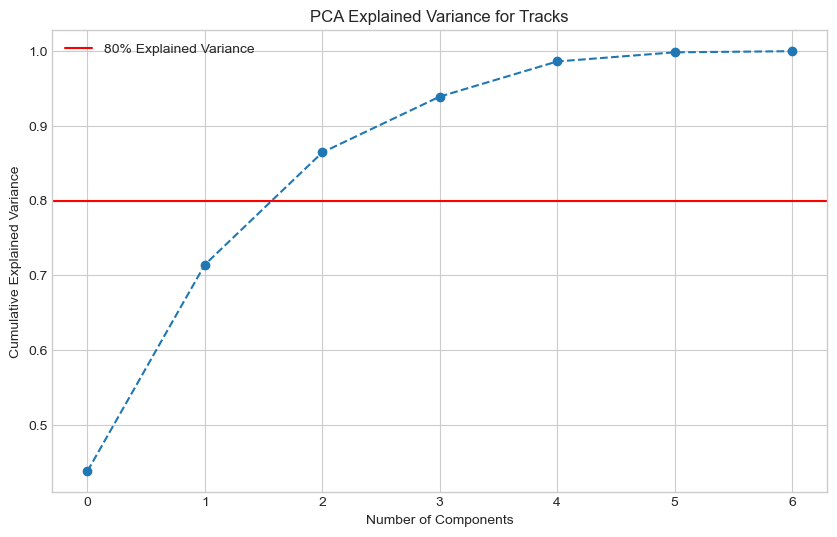

Choosing 3 components to explain >80% of the variance.

--- Track Classification Summary ---
                                       Archetype
track_identifier                                
spielberg              1: Power & Speed Circuits
jeddah                 1: Power & Speed Circuits
las_vegas              1: Power & Speed Circuits
monza                  1: Power & Speed Circuits
melbourne              1: Power & Speed Circuits
yas_marina             1: Power & Speed Circuits
austin                     2: Technical & High-G
baku                       2: Technical & High-G
singapore                  2: Technical & High-G
shanghai                   2: Technical & High-G
sakhir                     2: Technical & High-G
mexico_city                2: Technical & High-G
miami                      2: Technical & High-G
montreal                   2: Technical & High-G
monaco            3: High-Variance Engine Tracks
le_castellet            4: Balanced All-Rounders
sao_paulo               4

C:\Users\vaibh\anaconda3\envs\f1_pi\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


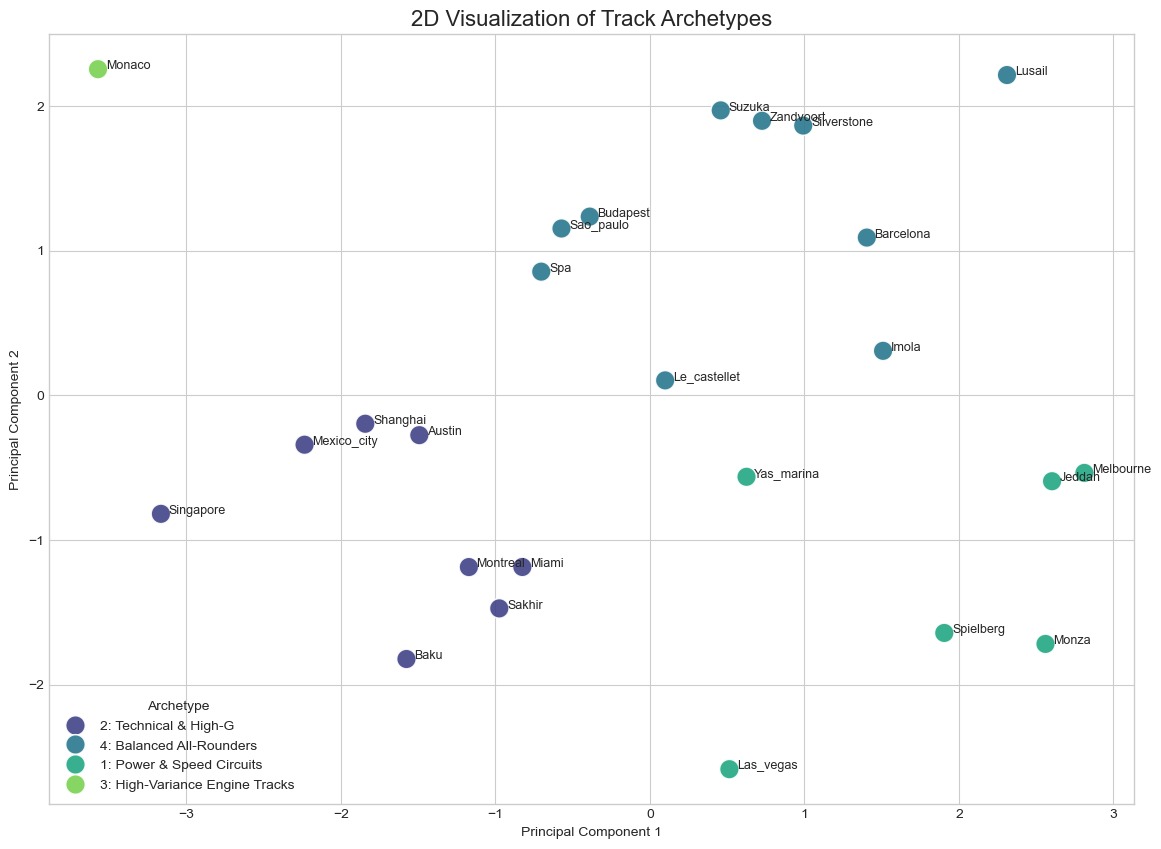


--- Starting Analysis for Driver Archetypes ---


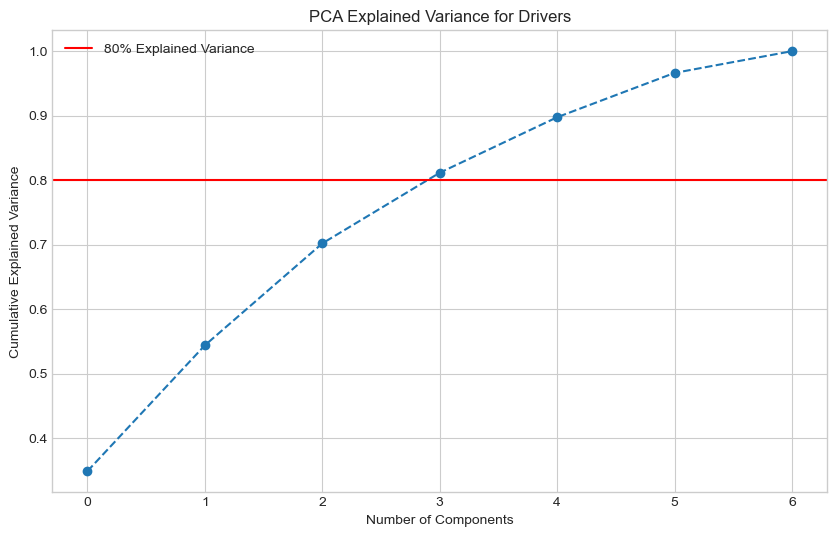

Choosing 4 components to explain >80% of the variance.

--- Driver Classification Summary ---
                              Archetype
driver                                 
NOR     B: Smooth & Consistent (High-G)
PIA     B: Smooth & Consistent (High-G)
RUS        C: Straight-Line Specialists
SAI        C: Straight-Line Specialists
HUL        C: Straight-Line Specialists
HAM        C: Straight-Line Specialists
HAD        C: Straight-Line Specialists
DOO        C: Straight-Line Specialists
LEC        C: Straight-Line Specialists
STR        C: Straight-Line Specialists
BEA        C: Straight-Line Specialists
ANT        C: Straight-Line Specialists
ALO        C: Straight-Line Specialists
DEV        C: Straight-Line Specialists
PER                   D: Balanced Style
TSU                   D: Balanced Style
VER                   D: Balanced Style
RIC                   D: Balanced Style
SAR                   D: Balanced Style
ALB                   D: Balanced Style
MSC                   D: B

C:\Users\vaibh\anaconda3\envs\f1_pi\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


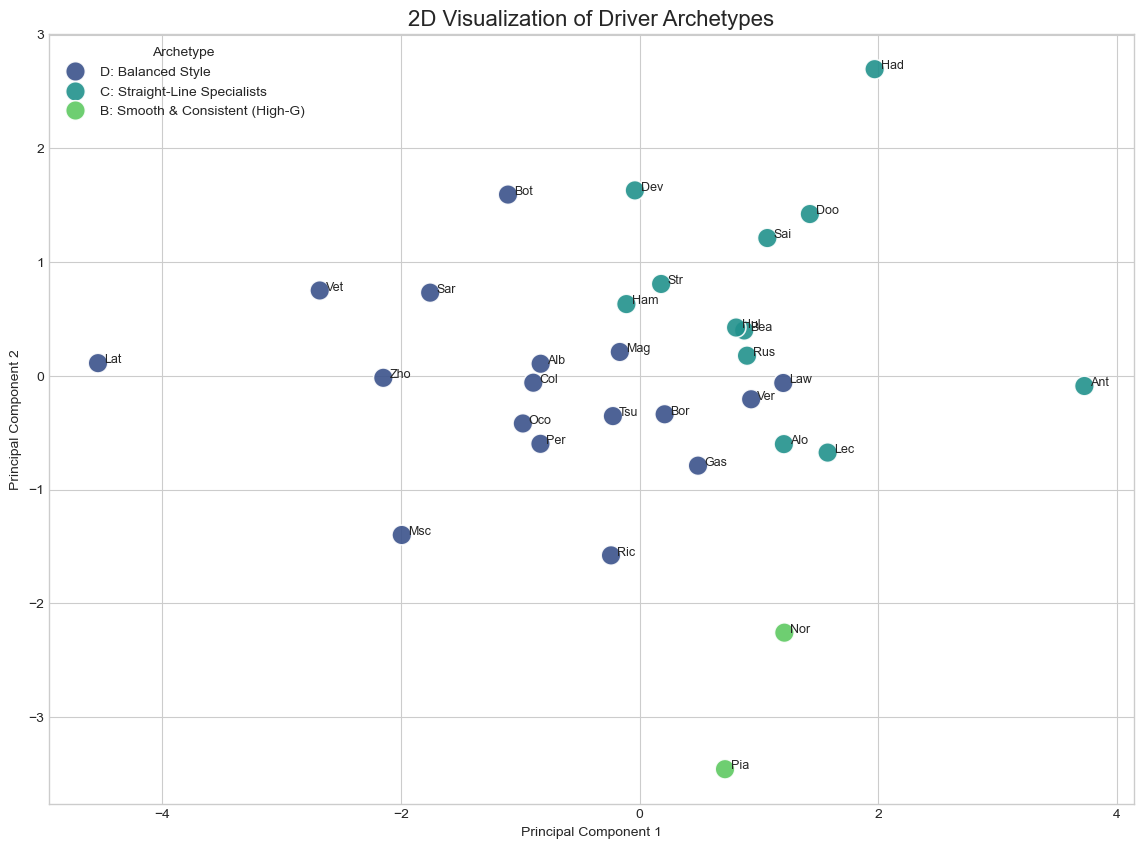

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def analyze_and_visualize_clusters(df_kpis, entity_type='track'):
    """
    Performs PCA, K-Means clustering, and visualization for a given entity (track or driver).

    Args:
        df_kpis (pd.DataFrame): The DataFrame containing lap-level KPIs.
        entity_type (str): The entity to cluster on. Must be 'track' or 'driver'.
    """
    if entity_type == 'track':
        grouping_col = 'track_identifier'
        features_to_use = ['Throttle_Full_Pct', 'Braking_Intensity', 'RPM_Avg', 'RPM_Std_Dev',
                           'Total_G_Mean', 'DRS_Uptime_Pct', 'Gear_Changes_per_Lap']
    elif entity_type == 'driver':
        grouping_col = 'driver'
        features_to_use = ['Throttle_Full_Pct', 'Braking_Intensity', 'RPM_Avg', 'RPM_Std_Dev',
                           'Total_G_Mean', 'DRS_Uptime_Pct', 'Gear_Changes_per_Lap']
    else:
        raise ValueError("entity_type must be 'track' or 'driver'")

    print(f"\n--- Starting Analysis for {entity_type.capitalize()} Archetypes ---")

    # 1. Aggregate KPIs by the chosen entity
    entity_kpis = df_kpis.groupby(grouping_col).mean(numeric_only=True)

    # Ensure we only use the specified features
    entity_kpis = entity_kpis[features_to_use]

    # 2. Impute and Scale Data
    imputer = SimpleImputer(strategy='mean')
    kpis_imputed = imputer.fit_transform(entity_kpis)

    scaler = StandardScaler()
    kpis_scaled = scaler.fit_transform(kpis_imputed)

    # 3. Apply PCA
    pca = PCA(n_components=None)
    pca.fit(kpis_scaled)

    # Scree Plot to determine optimal number of components
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'PCA Explained Variance for {entity_type.capitalize()}s')
    plt.axhline(y=0.8, color='r', linestyle='-', label='80% Explained Variance')
    plt.legend()
    plt.grid(True)
    plt.show()

    n_components = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.8)[0][0] + 1
    print(f"Choosing {n_components} components to explain >80% of the variance.")

    pca = PCA(n_components=n_components)
    entity_pca = pca.fit_transform(kpis_scaled)

    # 4. K-Means Clustering
    k = 4
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    entity_kpis['Cluster'] = kmeans.fit_predict(entity_pca)

    # 5. Dynamic Cluster Naming
    cluster_centers_original_scale = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_))
    cluster_centers = pd.DataFrame(
        cluster_centers_original_scale,
        columns=entity_kpis.drop(columns='Cluster').columns
    )

    cluster_map = {}
    if entity_type == 'track':
        # Find the cluster with the highest value for the defining feature of each archetype
        power_id = cluster_centers['Throttle_Full_Pct'].idxmax()
        tech_id = cluster_centers['Gear_Changes_per_Lap'].idxmax()
        variance_id = cluster_centers['RPM_Std_Dev'].idxmax()

        cluster_map[power_id] = '1: Power & Speed Circuits'
        cluster_map[tech_id] = '2: Technical & High-G'
        cluster_map[variance_id] = '3: High-Variance Engine Tracks'

        # Assign the remaining cluster as the 'Balanced' one
        remaining_ids = set(range(k)) - set(cluster_map.keys())
        for r_id in remaining_ids:
            cluster_map[r_id] = '4: Balanced All-Rounders'

    else: # driver
        # Find the cluster with the min/max value for the defining feature
        aggressive_id = cluster_centers['Braking_Intensity'].idxmin() # Most negative braking G
        smooth_id = cluster_centers['Total_G_Mean'].idxmax()
        straight_line_id = cluster_centers['Throttle_Full_Pct'].idxmax()

        cluster_map[aggressive_id] = 'A: Aggressive Brakers'
        cluster_map[smooth_id] = 'B: Smooth & Consistent (High-G)'
        cluster_map[straight_line_id] = 'C: Straight-Line Specialists'

        # Assign the remaining cluster as the 'Balanced' one
        remaining_ids = set(range(k)) - set(cluster_map.keys())
        for r_id in remaining_ids:
            cluster_map[r_id] = 'D: Balanced Style'

    entity_kpis['Archetype'] = entity_kpis['Cluster'].map(cluster_map)

    print(f"\n--- {entity_type.capitalize()} Classification Summary ---")
    print(entity_kpis[['Archetype']].sort_values('Archetype'))

    # 6. Visualization
    entity_kpis['PC1'] = entity_pca[:, 0]
    entity_kpis['PC2'] = entity_pca[:, 1]

    plt.figure(figsize=(14, 10))
    sns.scatterplot(x='PC1', y='PC2', hue='Archetype', data=entity_kpis, palette='viridis', s=200, alpha=0.9)

    for item_name, row in entity_kpis.iterrows():
        plt.text(row['PC1'] + 0.05, row['PC2'], item_name.capitalize(), fontsize=9)

    plt.title(f'2D Visualization of {entity_type.capitalize()} Archetypes', fontsize=16)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Archetype')
    plt.grid(True)
    plt.show()

# --- Run the full analysis pipeline ---
# 1. For Tracks
analyze_and_visualize_clusters(df_lap_kpis, entity_type='track')

# 2. For Drivers
analyze_and_visualize_clusters(df_lap_kpis, entity_type='driver')


### Phase 2: Granular Event Analysis

#### P2.1: Anomaly Detection with Isolation Forest


--- Running Anomaly Detection for track: Sakhir ---
  Calculating G-Forces...
  Training Isolation Forest model...


C:\Users\vaibh\AppData\Local\Temp\ipykernel_20520\1473168047.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  heading.fillna(method='bfill', inplace=True)


  Anomaly detection complete.


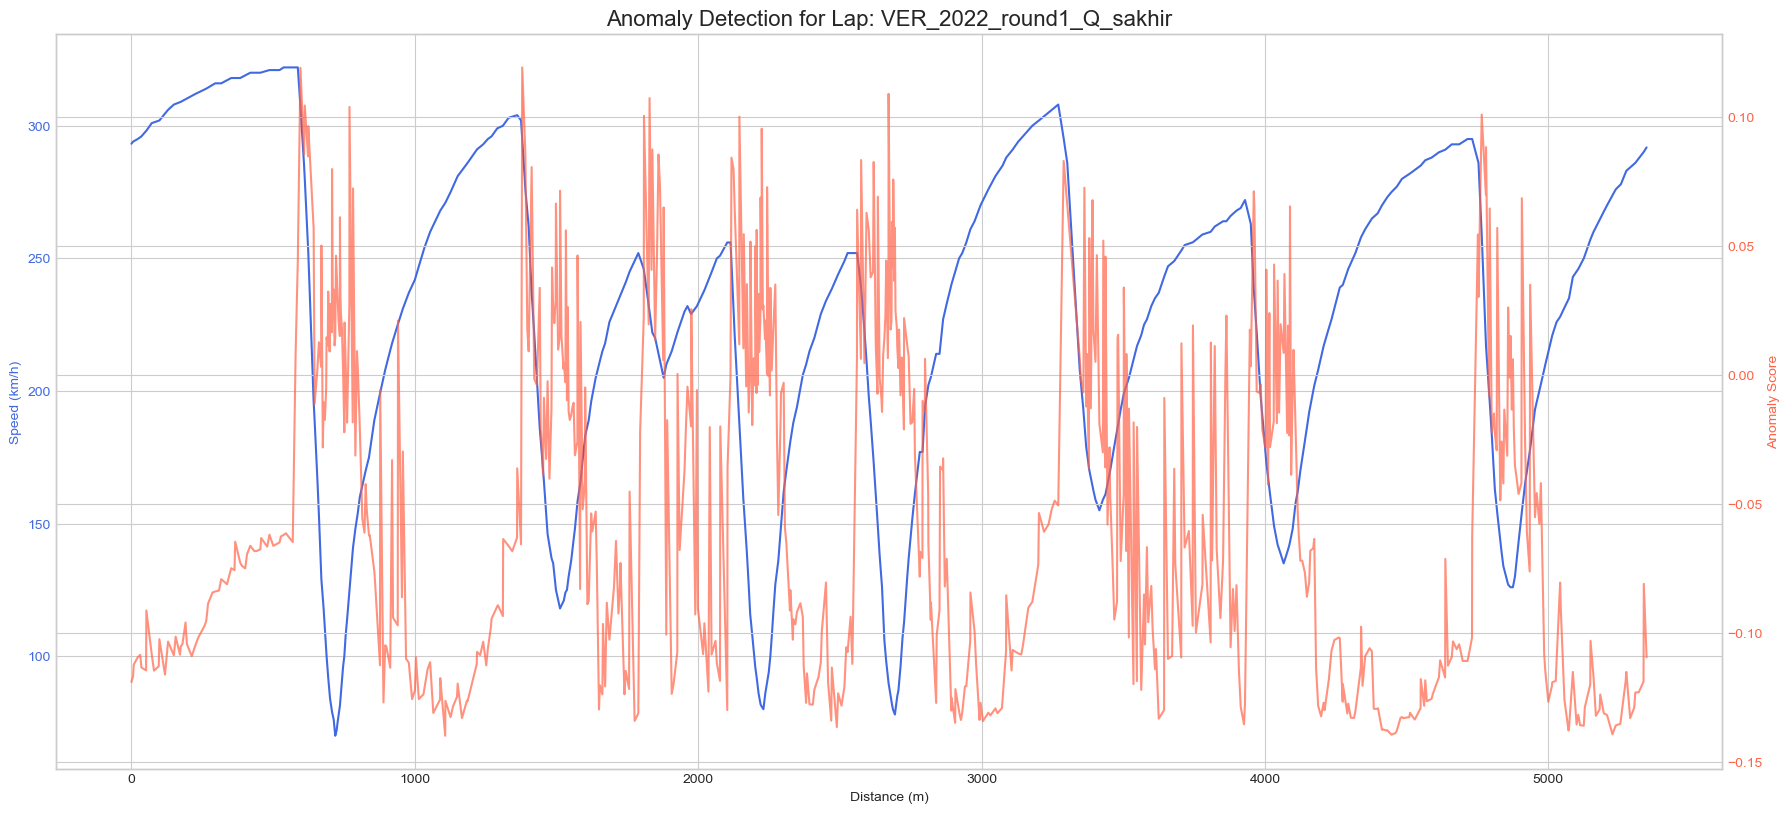

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# This function should be the one you have already corrected from Phase 1
def calculate_g_forces(lap_df):
    """
    Calculates G-forces. Ensure this is the corrected version from our previous steps.
    """
    lap_df = lap_df.copy()
    lap_df = lap_df.drop_duplicates(subset=['Time'], keep='first')
    lap_df['X_m'] = lap_df['X'] / 10
    lap_df['Y_m'] = lap_df['Y'] / 10
    time_diff = lap_df['Time'].diff().dt.total_seconds()
    speed_ms = lap_df['Speed'] / 3.6
    acceleration = speed_ms.diff() / time_diff
    lap_df['Lon_G'] = (acceleration / 9.81).clip(-8, 8)
    dx = lap_df['X_m'].rolling(5, center=True, min_periods=1).mean().diff()
    dy = lap_df['Y_m'].rolling(5, center=True, min_periods=1).mean().diff()
    heading = np.arctan2(dy, dx)
    heading.fillna(method='bfill', inplace=True)
    heading_unwrapped = np.unwrap(heading)
    angular_velocity = pd.Series(heading_unwrapped, index=lap_df.index).diff() / time_diff
    lat_accel = speed_ms * angular_velocity
    lap_df['Lat_G'] = (lat_accel / 9.81).clip(-8, 8)
    lap_df.fillna(0, inplace=True)
    return lap_df

def run_anomaly_detection(df_telemetry, track, features_to_use):
    """
    Runs Isolation Forest anomaly detection on telemetry data for a specific track.

    Args:
        df_telemetry (pd.DataFrame): The full, concatenated telemetry DataFrame.
        track (str): The 'track_identifier' to model.
        features_to_use (list): List of column names to use for training the model.

    Returns:
        pd.DataFrame: A DataFrame for the specified track with an added 'anomaly_score' column.
    """
    print(f"\n--- Running Anomaly Detection for track: {track.capitalize()} ---")

    # Filter data for the specific track
    track_df = df_telemetry[df_telemetry['track_identifier'] == track].copy()

    # Calculate G-forces as they are needed features
    print("  Calculating G-Forces...")
    track_df = calculate_g_forces(track_df)

    # Prepare data for the model
    X = track_df[features_to_use]

    # Impute and scale the features
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # Train the Isolation Forest model
    # `contamination` is the expected proportion of outliers. 'auto' is a good start.
    print("  Training Isolation Forest model...")
    iso_forest = IsolationForest(contamination='auto', random_state=42)
    iso_forest.fit(X_scaled)

    # Get anomaly scores. The `decision_function` gives a raw score where
    # more negative values are more anomalous. We invert it so higher is more anomalous.
    raw_scores = iso_forest.decision_function(X_scaled)
    track_df['anomaly_score'] = -raw_scores

    print("  Anomaly detection complete.")
    return track_df

def plot_lap_anomalies(lap_df):
    """
    Visualizes the anomaly score over the course of a single lap.

    Args:
        lap_df (pd.DataFrame): The telemetry DataFrame for a single lap,
                               including the 'anomaly_score' column.
    """
    lap_id = lap_df['driver_lap_id'].iloc[0]
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax1 = plt.subplots(figsize=(18, 8))

    # Plot Speed on the primary y-axis
    color = 'royalblue'
    ax1.set_xlabel('Distance (m)')
    ax1.set_ylabel('Speed (km/h)', color=color)
    ax1.plot(lap_df['Distance'], lap_df['Speed'], color=color, label='Speed')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot Anomaly Score on the secondary y-axis
    ax2 = ax1.twinx()
    color = 'tomato'
    ax2.set_ylabel('Anomaly Score', color=color)
    ax2.plot(lap_df['Distance'], lap_df['anomaly_score'], color=color, alpha=0.7, label='Anomaly Score')
    ax2.tick_params(axis='y', labelcolor=color)

    # Highlight anomalous regions
    anomaly_threshold = lap_df['anomaly_score'].quantile(0.99) # Highlight top 1%
    ax2.fill_between(lap_df['Distance'], lap_df['anomaly_score'], anomaly_threshold,
                     where=lap_df['anomaly_score'] > anomaly_threshold,
                     facecolor='tomato', alpha=0.3, interpolate=True)

    fig.tight_layout()
    plt.title(f'Anomaly Detection for Lap: {lap_id}', fontsize=16)
    plt.show()


# Define the features to use for anomaly detection
anomaly_features = ['Speed', 'RPM', 'Throttle', 'Lon_G', 'Lat_G']

# Run the pipeline for a specific track
df_sakhir_anomalies = run_anomaly_detection(df_all_telemetry, 'sakhir', anomaly_features)

# Visualize the anomalies for a specific lap
ver_lap = df_sakhir_anomalies[df_sakhir_anomalies['driver_lap_id'] == 'VER_2022_round1_Q_sakhir']
if not ver_lap.empty:
    plot_lap_anomalies(ver_lap)


#### P2.2: Four-Quadrant Anomaly Analysis


--- Creating Four-Quadrant Analysis for Driver: LEC ---
  Using lap 'LEC_2022_round1_Q_sakhir' as the reference lap.


C:\Users\vaibh\AppData\Local\Temp\ipykernel_20520\452165071.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sector_analysis = lap_df.groupby('sector').agg(
C:\Users\vaibh\AppData\Local\Temp\ipykernel_20520\452165071.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sector_analysis = lap_df.groupby('sector').agg(
C:\Users\vaibh\AppData\Local\Temp\ipykernel_20520\452165071.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this 

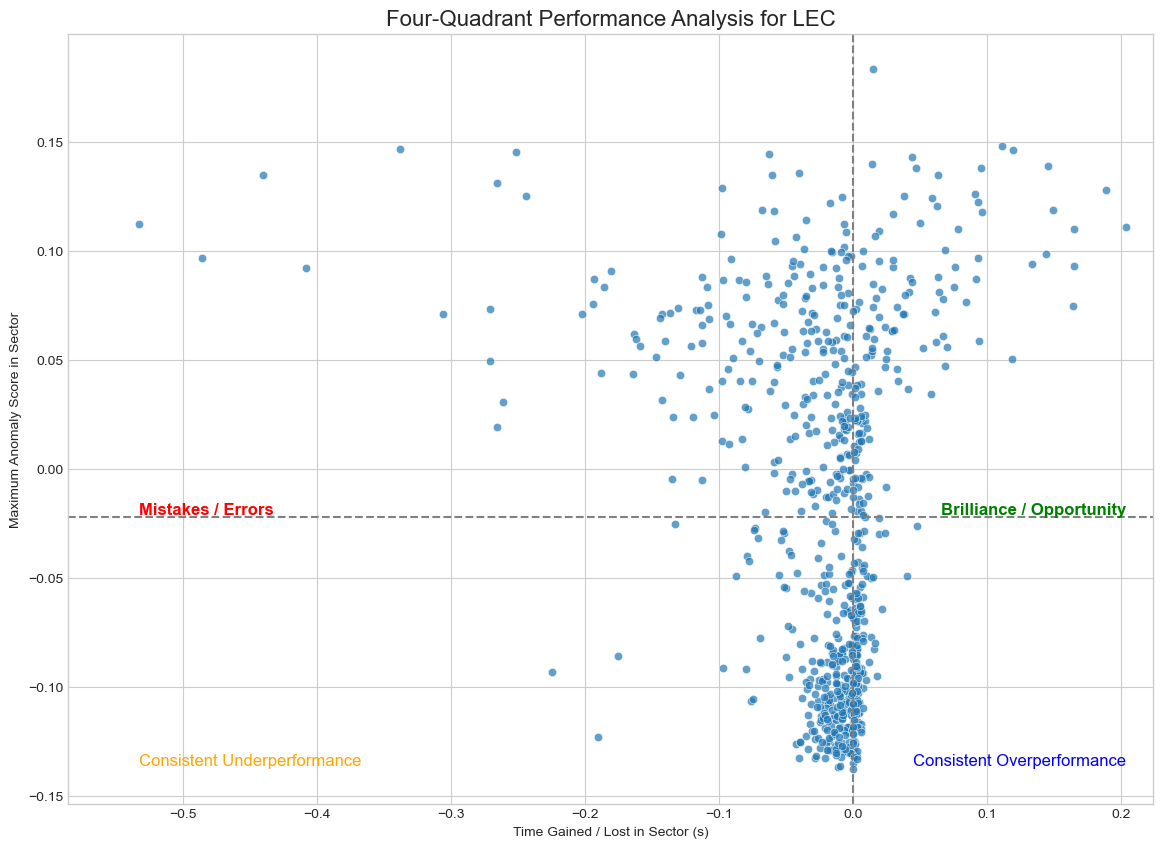


--- Creating Four-Quadrant Analysis for Driver: RIC ---
  Using lap 'RIC_2022_round1_Q_sakhir' as the reference lap.


C:\Users\vaibh\AppData\Local\Temp\ipykernel_20520\452165071.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sector_analysis = lap_df.groupby('sector').agg(
C:\Users\vaibh\AppData\Local\Temp\ipykernel_20520\452165071.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sector_analysis = lap_df.groupby('sector').agg(
C:\Users\vaibh\AppData\Local\Temp\ipykernel_20520\452165071.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this 

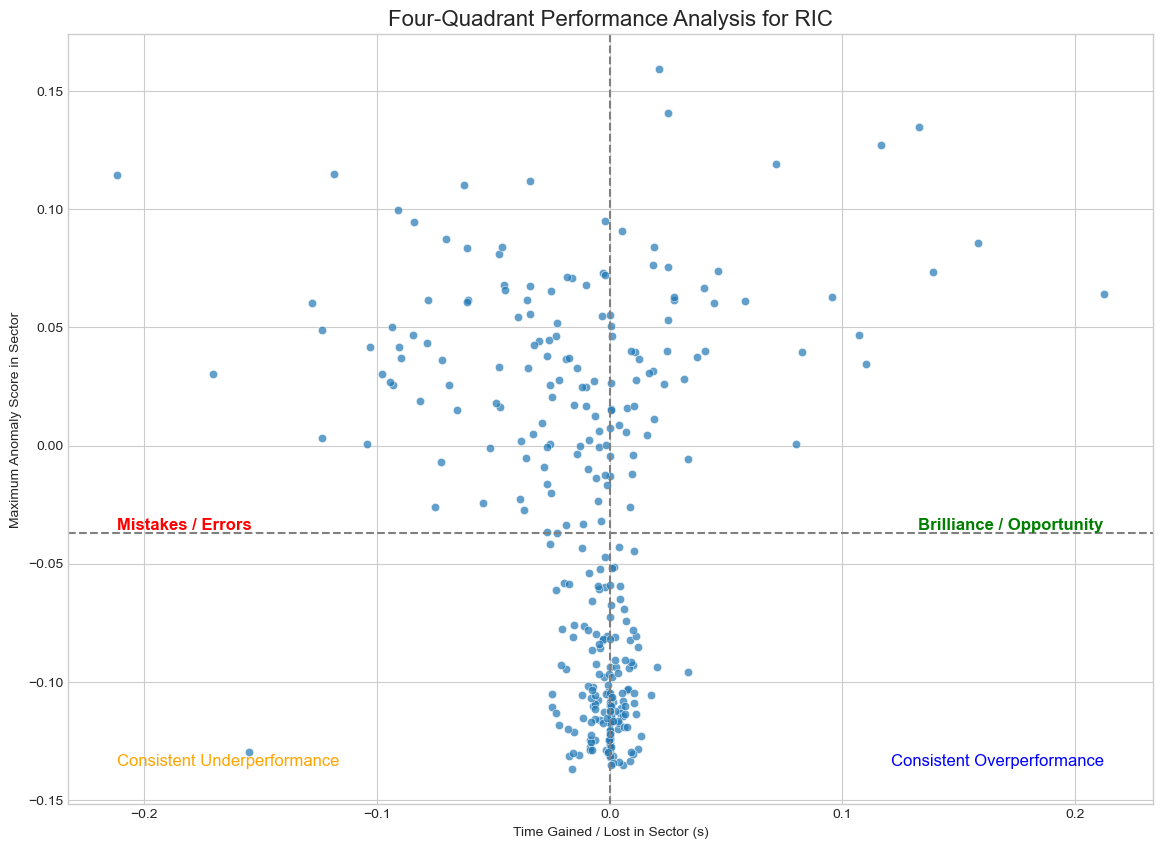

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume the anomaly detection script ('phase2_anomaly_detection') has been run,
# and we have a DataFrame like 'df_sakhir_anomalies' available.

def calculate_time_delta(lap_df, ref_lap_df):
    """
    Calculates the time delta of a lap compared to a reference lap.

    Args:
        lap_df (pd.DataFrame): The current lap's telemetry data.
        ref_lap_df (pd.DataFrame): The reference lap's telemetry data.

    Returns:
        pd.DataFrame: The current lap's DataFrame with a new 'time_delta' column.
    """
    lap_df = lap_df.copy()

    # Interpolate the reference lap's time onto the current lap's distance markers
    ref_time_interp = np.interp(lap_df['Distance'], ref_lap_df['Distance'], ref_lap_df['Time'].dt.total_seconds())

    # The time delta is the difference. A negative value means the current lap is faster.
    lap_df['time_delta'] = lap_df['Time'].dt.total_seconds() - ref_time_interp

    return lap_df

def analyze_and_plot_quadrants(df_anomalies, driver, sector_length=50):
    """
    Analyzes all laps for a driver at a track and creates the four-quadrant plot.

    Args:
        df_anomalies (pd.DataFrame): DataFrame for a single track with anomaly scores.
        driver (str): The driver to analyze.
        sector_length (int): The length of each micro-sector in meters.
    """
    print(f"\n--- Creating Four-Quadrant Analysis for Driver: {driver} ---")

    driver_laps = df_anomalies[df_anomalies['driver'] == driver].copy()

    # Find the fastest lap for this driver to use as a reference
    # For this, we need lap times. Since we don't have them, we'll use the first lap as reference.
    # In a real scenario, you'd join with lap time data to find the actual fastest lap.
    ref_lap_id = driver_laps['driver_lap_id'].unique()[0]
    ref_lap_df = driver_laps[driver_laps['driver_lap_id'] == ref_lap_id]
    print(f"  Using lap '{ref_lap_id}' as the reference lap.")

    all_sectors = []

    # Analyze every other lap against the reference
    for lap_id in driver_laps['driver_lap_id'].unique():
        if lap_id == ref_lap_id:
            continue

        lap_df = driver_laps[driver_laps['driver_lap_id'] == lap_id]

        # Calculate time delta for the lap
        lap_df = calculate_time_delta(lap_df, ref_lap_df)

        # Create micro-sectors
        max_dist = int(lap_df['Distance'].max())
        lap_df['sector'] = pd.cut(lap_df['Distance'], bins=np.arange(0, max_dist + sector_length, sector_length), right=False)

        # Aggregate by sector
        sector_analysis = lap_df.groupby('sector').agg(
            max_anomaly=('anomaly_score', 'max'),
            time_gain_loss=('time_delta', lambda x: -x.diff().sum()) # Negative delta is gain
        ).dropna()

        all_sectors.append(sector_analysis)

    if not all_sectors:
        print(f"  Not enough laps for driver {driver} to perform quadrant analysis.")
        return

    df_quadrant = pd.concat(all_sectors)

    # --- Visualization ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 10))

    # Define quadrant boundaries
    mean_anomaly = df_quadrant['max_anomaly'].mean()

    # Scatter plot
    sns.scatterplot(data=df_quadrant, x='time_gain_loss', y='max_anomaly', alpha=0.7)

    # Add quadrant lines and labels
    plt.axhline(mean_anomaly, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')

    plt.text(df_quadrant['time_gain_loss'].max(), mean_anomaly, 'Brilliance / Opportunity', ha='right', va='bottom', color='green', fontsize=12, weight='bold')
    plt.text(df_quadrant['time_gain_loss'].min(), mean_anomaly, 'Mistakes / Errors', ha='left', va='bottom', color='red', fontsize=12, weight='bold')
    plt.text(df_quadrant['time_gain_loss'].max(), df_quadrant['max_anomaly'].min(), 'Consistent Overperformance', ha='right', va='bottom', color='blue', fontsize=12)
    plt.text(df_quadrant['time_gain_loss'].min(), df_quadrant['max_anomaly'].min(), 'Consistent Underperformance', ha='left', va='bottom', color='orange', fontsize=12)

    plt.title(f'Four-Quadrant Performance Analysis for {driver}', fontsize=16)
    plt.xlabel('Time Gained / Lost in Sector (s)')
    plt.ylabel('Maximum Anomaly Score in Sector')
    plt.xlim(df_quadrant['time_gain_loss'].min()*1.1, df_quadrant['time_gain_loss'].max()*1.1)
    plt.show()

# Run the quadrant analysis for a specific driver
analyze_and_plot_quadrants(df_sakhir_anomalies, driver='LEC')
analyze_and_plot_quadrants(df_sakhir_anomalies, driver='RIC')

#### P2.3: Time-Series Clustering with k-Shape

--- Running analysis on a sample of 1000 laps ---
--- Finding all significant braking zones ---


C:\Users\vaibh\AppData\Local\Temp\ipykernel_20520\1130581601.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  start_indices = lap_df.index[is_braking & ~is_braking.shift(1).fillna(False)]
C:\Users\vaibh\AppData\Local\Temp\ipykernel_20520\1130581601.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  end_indices = lap_df.index[~is_braking & is_braking.shift(1).fillna(False)]


Found braking zones in 996 laps.

--- Extracting features from speed traces ---
Extracted features for 7009 traces.
   initial_speed  min_speed  speed_drop  avg_deceleration  shape_metric
0          266.0      133.0       133.0         62.735849      0.382425
1          297.0       72.0       225.0         66.176471      0.319981
2          284.0      122.0       162.0         77.884615      0.437660
3          263.0      179.0        84.0         43.727225      0.381950
4          289.0      220.0        69.0         41.071429      0.515421

--- Scaling features ---

--- Running KMeans clustering ---

--- Visualizing cluster centroids ---


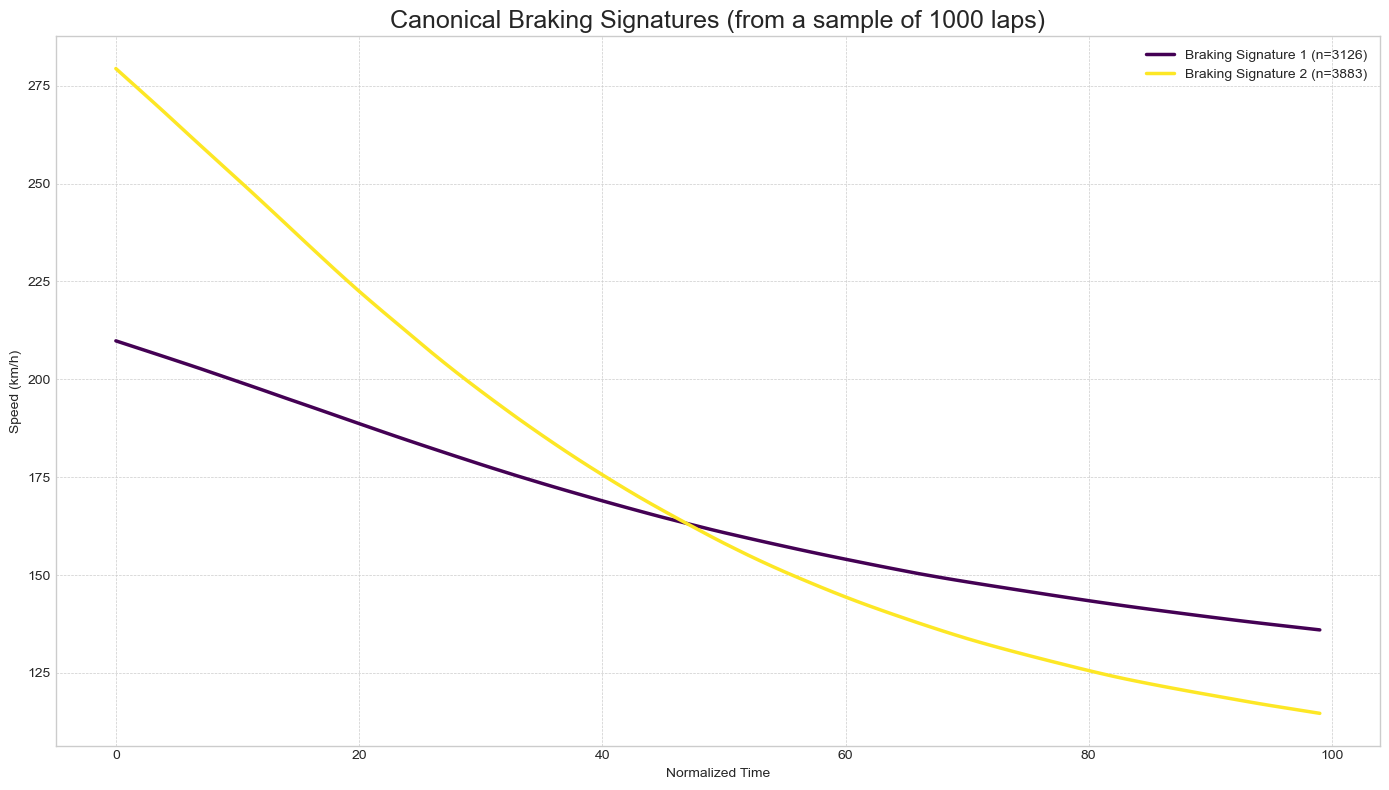

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def find_braking_zones(lap_df, brake_threshold=0.1, min_duration=1.0):
    """
    Identifies significant braking zones within a single lap's telemetry.

    Args:
        lap_df (pd.DataFrame): Telemetry data for one lap.
        brake_threshold (float): The threshold to consider the brake as 'on'.
        min_duration (float): The minimum duration in seconds for a braking event.

    Returns:
        list: A list of tuples, where each tuple is the start and end index
              of a significant braking zone.
    """
    is_braking = lap_df['Brake'] > brake_threshold
    start_indices = lap_df.index[is_braking & ~is_braking.shift(1).fillna(False)]
    end_indices = lap_df.index[~is_braking & is_braking.shift(1).fillna(False)]

    braking_zones = []
    for start in start_indices:
        end = next((e for e in end_indices if e > start), None)
        if end and end > start:
            # Ensure Time column exists and is timedelta before using .loc
            if 'Time' in lap_df.columns and pd.api.types.is_timedelta64_dtype(lap_df['Time']):
                 duration = (lap_df.loc[end, 'Time'] - lap_df.loc[start, 'Time']).total_seconds()
                 if duration >= min_duration:
                    braking_zones.append((start, end))
            else: # Fallback if Time column is missing or not timedelta
                braking_zones.append((start, end))

    return braking_zones

def extract_trace_features(df_telemetry, zones, column='Speed'):
    """
    Extracts descriptive features from each time-series trace.

    Args:
        df_telemetry (pd.DataFrame): The full telemetry DataFrame.
        zones (dict): A dictionary mapping lap_id to a list of (start, end) indices.
        column (str): The telemetry channel to extract features from.

    Returns:
        pd.DataFrame: A DataFrame where each row represents a braking zone's features.
        list: A list of the original trace arrays for visualization later.
    """
    all_features = []
    original_traces = []

    for lap_id, zone_indices in zones.items():
        lap_df = df_telemetry[df_telemetry['driver_lap_id'] == lap_id]
        for start, end in zone_indices:
            trace = lap_df.loc[start:end][column].values
            if len(trace) < 2: continue

            initial_speed = trace[0]
            min_speed = np.min(trace)
            speed_drop = initial_speed - min_speed

            # Calculate average deceleration
            duration = (lap_df.loc[end, 'Time'] - lap_df.loc[start, 'Time']).total_seconds()
            avg_deceleration = speed_drop / duration if duration > 0 else 0

            # Feature to approximate "V-ness" vs "U-ness"
            normalized_trace = (trace - min_speed) / (speed_drop if speed_drop > 0 else 1)
            shape_metric = np.mean(normalized_trace) # Higher value means more "U-shaped"

            all_features.append({
                'initial_speed': initial_speed,
                'min_speed': min_speed,
                'speed_drop': speed_drop,
                'avg_deceleration': avg_deceleration,
                'shape_metric': shape_metric
            })
            original_traces.append(trace)

    return pd.DataFrame(all_features), original_traces

def plot_braking_signatures(traces, labels, n_clusters, n_laps_sampled, length=100):
    """
    Visualizes the mean trace for each cluster of braking signatures on a single plot.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 8))

    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

    for i in range(n_clusters):
        cluster_traces = [traces[j] for j, label in enumerate(labels) if label == i]

        if not cluster_traces: continue

        # Normalize all traces in the cluster to a fixed length for averaging
        normalized_cluster_traces = []
        for trace in cluster_traces:
            original_indices = np.linspace(0, 1, len(trace))
            target_indices = np.linspace(0, 1, length)
            normalized_trace = np.interp(target_indices, original_indices, trace)
            normalized_cluster_traces.append(normalized_trace)

        mean_trace = np.mean(normalized_cluster_traces, axis=0)

        plt.plot(mean_trace, label=f'Braking Signature {i+1} (n={len(cluster_traces)})', color=colors[i], linewidth=2.5)

    plt.title(f'Canonical Braking Signatures (from a sample of {n_laps_sampled} laps)', fontsize=18)
    plt.xlabel('Normalized Time')
    plt.ylabel('Speed (km/h)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


# 1. Sample a subset of laps to speed up the process
n_laps_to_sample = 1000
all_lap_ids = df_all_telemetry['driver_lap_id'].unique()
laps_to_process = np.random.choice(all_lap_ids, size=min(n_laps_to_sample, len(all_lap_ids)), replace=False)
df_sample = df_all_telemetry[df_all_telemetry['driver_lap_id'].isin(laps_to_process)]
print(f"--- Running analysis on a sample of {len(laps_to_process)} laps ---")


# 2. Find all braking zones in the sampled laps
print("--- Finding all significant braking zones ---")
all_braking_zones = {}
for lap_id, lap_df in df_sample.groupby('driver_lap_id'):
    zones = find_braking_zones(lap_df)
    if zones:
        all_braking_zones[lap_id] = zones
print(f"Found braking zones in {len(all_braking_zones)} laps.")

# 3. Extract features from each trace
print("\n--- Extracting features from speed traces ---")
df_trace_features, original_traces = extract_trace_features(df_sample, all_braking_zones, column='Speed')
print(f"Extracted features for {len(df_trace_features)} traces.")
print(df_trace_features.head())

# 4. Scale the features
print("\n--- Scaling features ---")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_trace_features)

# 5. Run KMeans clustering
print("\n--- Running KMeans clustering ---")
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(features_scaled)

# 6. Visualize the resulting "braking signatures"
print("\n--- Visualizing cluster centroids ---")
plot_braking_signatures(original_traces, labels, n_clusters, len(laps_to_process))


--- Comparing braking signatures for HAM and VER ---
--- Finding all significant braking zones ---


C:\Users\vaibh\AppData\Local\Temp\ipykernel_20520\4019294435.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  start_indices = lap_df.index[is_braking & ~is_braking.shift(1).fillna(False)]
C:\Users\vaibh\AppData\Local\Temp\ipykernel_20520\4019294435.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  end_indices = lap_df.index[~is_braking & is_braking.shift(1).fillna(False)]


Found braking zones in 379 laps.

--- Extracting features from speed traces ---
Extracted features for 2580 traces.

--- Scaling features ---

--- Running KMeans clustering ---

--- Visualizing cluster centroids per driver ---


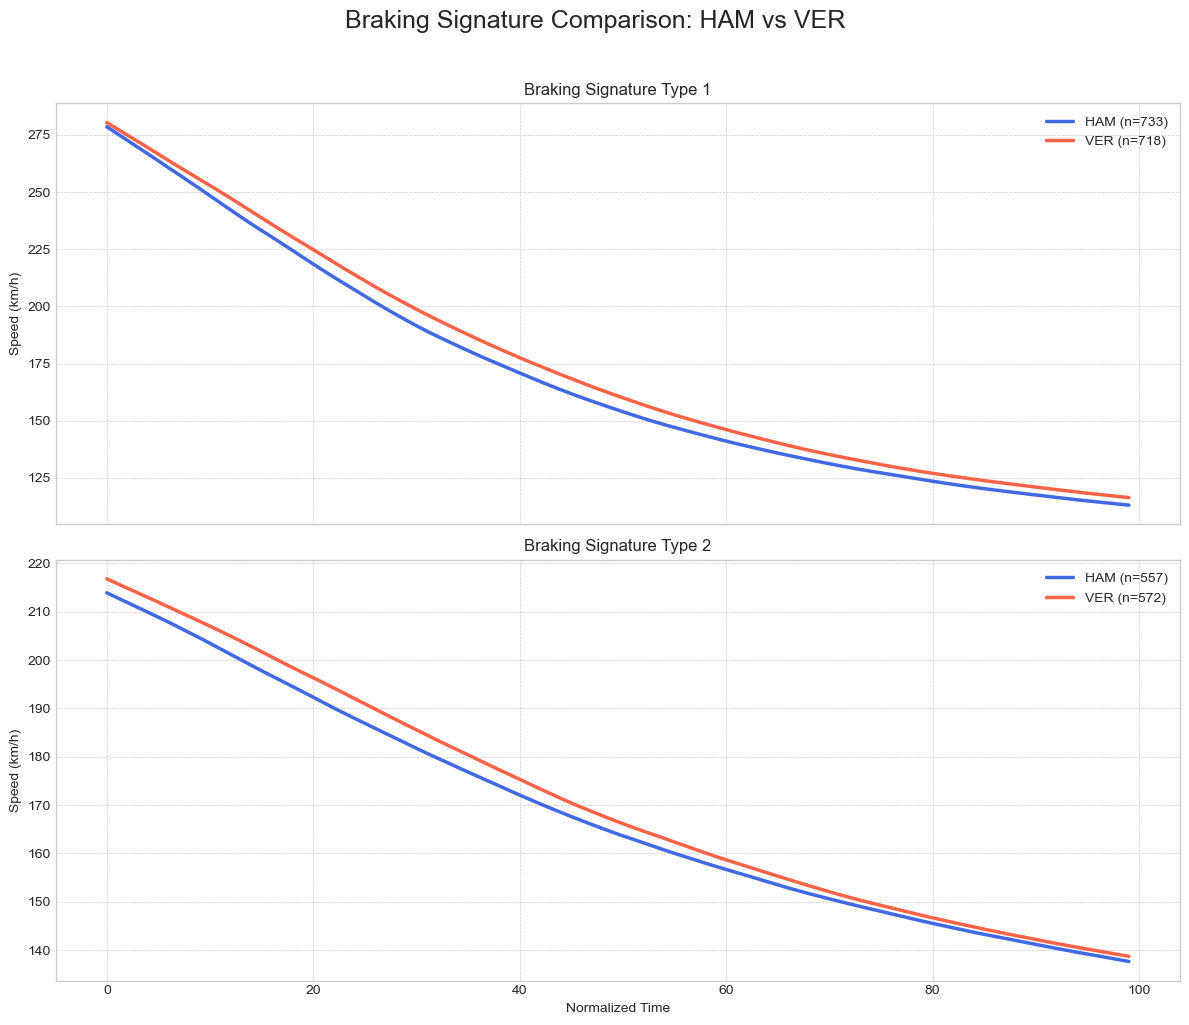

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def find_braking_zones(lap_df, brake_threshold=0.1, min_duration=1.0):
    """
    Identifies significant braking zones within a single lap's telemetry.
    """
    is_braking = lap_df['Brake'] > brake_threshold
    start_indices = lap_df.index[is_braking & ~is_braking.shift(1).fillna(False)]
    end_indices = lap_df.index[~is_braking & is_braking.shift(1).fillna(False)]

    braking_zones = []
    for start in start_indices:
        end = next((e for e in end_indices if e > start), None)
        if end and end > start:
            if 'Time' in lap_df.columns and pd.api.types.is_timedelta64_dtype(lap_df['Time']):
                 duration = (lap_df.loc[end, 'Time'] - lap_df.loc[start, 'Time']).total_seconds()
                 if duration >= min_duration:
                    braking_zones.append((start, end))
            else:
                braking_zones.append((start, end))
    return braking_zones

def extract_trace_features(df_telemetry, zones, column='Speed'):
    """
    Extracts descriptive features and original traces from each braking zone.
    """
    all_features = []
    original_traces = []

    for lap_id, zone_indices in zones.items():
        lap_df = df_telemetry[df_telemetry['driver_lap_id'] == lap_id]
        driver = lap_df['driver'].iloc[0]
        for start, end in zone_indices:
            trace = lap_df.loc[start:end][column].values
            if len(trace) < 2: continue

            initial_speed = trace[0]
            min_speed = np.min(trace)
            speed_drop = initial_speed - min_speed
            duration = (lap_df.loc[end, 'Time'] - lap_df.loc[start, 'Time']).total_seconds()
            avg_deceleration = speed_drop / duration if duration > 0 else 0
            normalized_trace = (trace - min_speed) / (speed_drop if speed_drop > 0 else 1)
            shape_metric = np.mean(normalized_trace)

            all_features.append({
                'driver': driver, # Keep track of the driver
                'initial_speed': initial_speed,
                'min_speed': min_speed,
                'speed_drop': speed_drop,
                'avg_deceleration': avg_deceleration,
                'shape_metric': shape_metric
            })
            original_traces.append(trace)

    return pd.DataFrame(all_features), original_traces

def plot_driver_comparison_signatures(df_features, traces, labels, driver1, driver2, n_clusters, length=100):
    """
    Visualizes the mean trace for each driver within each cluster.
    """
    df_features['label'] = labels
    df_features['trace'] = traces

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(n_clusters, 1, figsize=(12, n_clusters * 5), sharex=True)
    if n_clusters == 1: axes = [axes] # Make sure axes is always iterable
    fig.suptitle(f'Braking Signature Comparison: {driver1} vs {driver2}', fontsize=18, y=1.02)

    for i in range(n_clusters):
        ax = axes[i]
        cluster_df = df_features[df_features['label'] == i]

        for driver, color in zip([driver1, driver2], ['royalblue', 'tomato']):
            driver_traces = cluster_df[cluster_df['driver'] == driver]['trace'].tolist()
            if not driver_traces: continue

            normalized_traces = []
            for trace in driver_traces:
                original_indices = np.linspace(0, 1, len(trace))
                target_indices = np.linspace(0, 1, length)
                normalized_trace = np.interp(target_indices, original_indices, trace)
                normalized_traces.append(normalized_trace)

            mean_trace = np.mean(normalized_traces, axis=0)
            ax.plot(mean_trace, label=f'{driver} (n={len(driver_traces)})', color=color, linewidth=2.5)

        ax.set_title(f'Braking Signature Type {i+1}')
        ax.set_ylabel('Speed (km/h)')
        ax.legend()
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.xlabel('Normalized Time')
    plt.tight_layout()
    plt.show()


# 1. Filter for the drivers you want to compare
driver1, driver2 = 'HAM', 'VER'
df_sample = df_all_telemetry[df_all_telemetry['driver'].isin([driver1, driver2])]
print(f"--- Comparing braking signatures for {driver1} and {driver2} ---")


# 2. Find all braking zones for these drivers
print("--- Finding all significant braking zones ---")
all_braking_zones = {}
for lap_id, lap_df in df_sample.groupby('driver_lap_id'):
    zones = find_braking_zones(lap_df)
    if zones:
        all_braking_zones[lap_id] = zones
print(f"Found braking zones in {len(all_braking_zones)} laps.")

# 3. Extract features from each trace
print("\n--- Extracting features from speed traces ---")
df_trace_features, original_traces = extract_trace_features(df_sample, all_braking_zones, column='Speed')
print(f"Extracted features for {len(df_trace_features)} traces.")

# 4. Scale the features
print("\n--- Scaling features ---")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_trace_features.drop(columns=['driver']))

# 5. Run KMeans clustering
print("\n--- Running KMeans clustering ---")
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(features_scaled)

# 6. Visualize the driver comparison
print("\n--- Visualizing cluster centroids per driver ---")
plot_driver_comparison_signatures(df_trace_features, original_traces, labels, driver1, driver2, n_clusters)


### Phase 3: Codifying Insights with Association Rule Mining


==================== ANALYSIS FOR MONZA ====================
--- Discretizing telemetry data for Monza ---

--- Mining for association rules in Monza data ---

--- Discovered Driving Rules ---
                    antecedents_str                 consequents_str  support  \
26  Gear_8, Throttle_Full, RPM_High                 Speed_Very_High     0.14   
31   Throttle_Full, Speed_Very_High                Gear_8, RPM_High     0.14   
30                 Gear_8, RPM_High  Throttle_Full, Speed_Very_High     0.14   
23                  Speed_Very_High                Gear_8, RPM_High     0.18   
20                 Gear_8, RPM_High                 Speed_Very_High     0.18   

    confidence  lift  
26        0.95  3.78  
31        0.73  3.76  
30        0.70  3.76  
23        0.73  3.76  
20        0.94  3.76  

--- Visualizing rule: IF (Throttle_Full, Speed_Very_High) THEN (Gear_8, RPM_High) ---


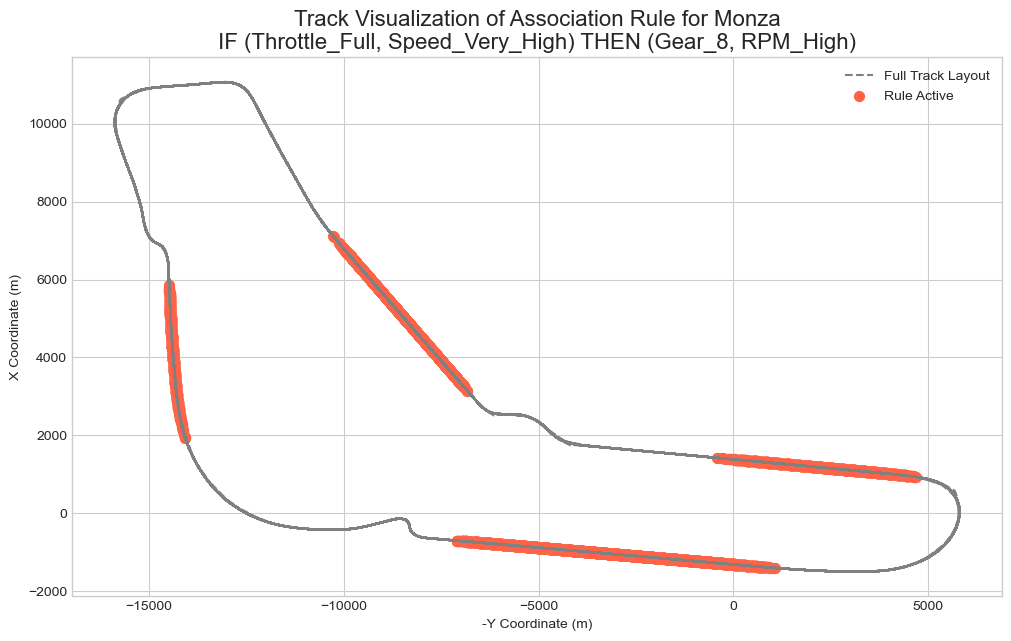


==================== ANALYSIS FOR MONACO ====================
--- Discretizing telemetry data for Monaco ---

--- Mining for association rules in Monaco data ---

--- Discovered Driving Rules ---
                                    antecedents_str  \
94                Gear_2, RPM_Low, Throttle_Partial   
86                Gear_2, RPM_Low, Throttle_Partial   
90  Gear_2, RPM_Low, DRS_Inactive, Throttle_Partial   
89                      Speed_Low, Throttle_Partial   
98                      Speed_Low, Throttle_Partial   

                  consequents_str  support  confidence  lift  
94        Speed_Low, DRS_Inactive      0.1        0.96  3.84  
86                      Speed_Low      0.1        0.96  3.84  
90                      Speed_Low      0.1        0.96  3.84  
89                Gear_2, RPM_Low      0.1        0.73  3.63  
98  Gear_2, RPM_Low, DRS_Inactive      0.1        0.73  3.63  

--- Visualizing rule: IF (Speed_Low, Throttle_Partial) THEN (Gear_2, RPM_Low) ---


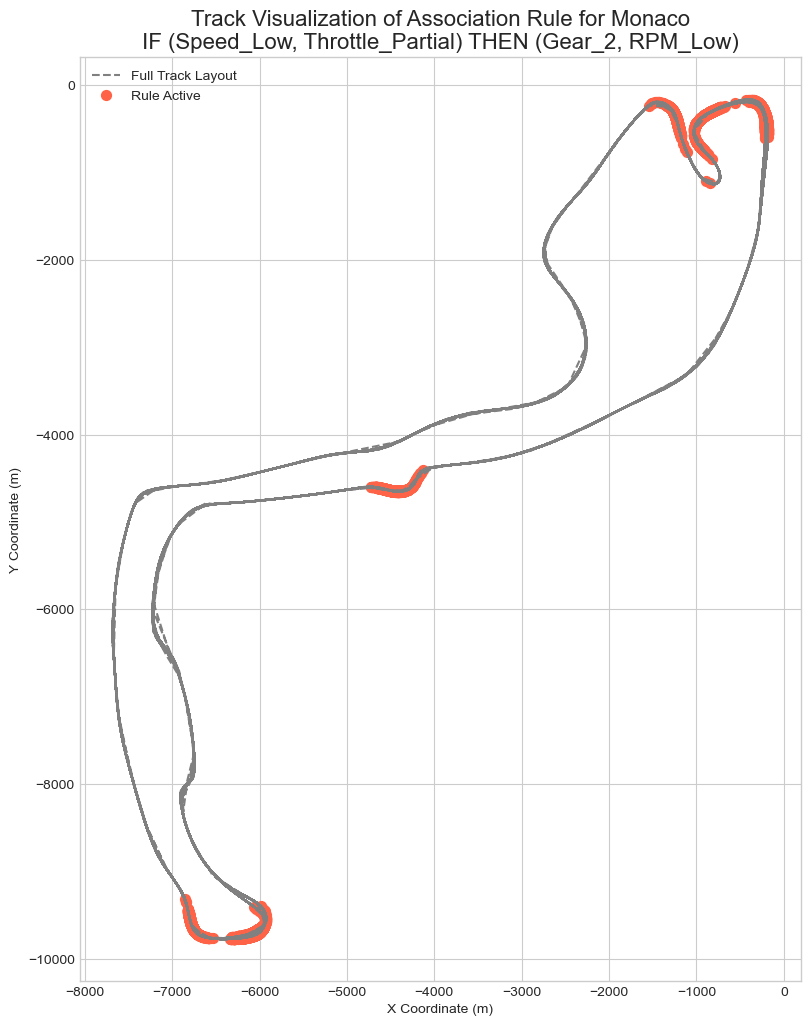

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# You may need to install mlxtend: pip install mlxtend
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder

def discretize_telemetry(df, track):
    """
    Discretizes continuous telemetry data into categorical bins for a specific track.

    Args:
        df (pd.DataFrame): The full telemetry DataFrame.
        track (str): The track_identifier to process.

    Returns:
        pd.DataFrame: The DataFrame for the track with binned columns.
    """
    track_df = df[df['track_identifier'] == track].copy()

    # Define bins for continuous variables
    # Speed bins (Low, Medium, High, Very High)
    track_df['Speed_Bin'] = pd.qcut(track_df['Speed'], 4, labels=['Speed_Low', 'Speed_Medium', 'Speed_High', 'Speed_Very_High'], duplicates='drop')

    # Throttle bins (Off, Partial, Full)
    throttle_bins = [-1, 1, 99, 101]
    track_df['Throttle_Bin'] = pd.cut(track_df['Throttle'], bins=throttle_bins, labels=['Throttle_Off', 'Throttle_Partial', 'Throttle_Full'])

    # RPM bins (Low, Medium, High)
    track_df['RPM_Bin'] = pd.qcut(track_df['RPM'], 3, labels=['RPM_Low', 'RPM_Medium', 'RPM_High'], duplicates='drop')

    # Also include categorical data like DRS and Gear
    track_df['DRS_Status'] = track_df['DRS'].apply(lambda x: 'DRS_Active' if x > 10 else 'DRS_Inactive')
    track_df['Gear'] = 'Gear_' + track_df['nGear'].astype(str)

    return track_df

def run_association_rule_mining(df_binned):
    """
    Performs association rule mining on the binned telemetry data.

    Args:
        df_binned (pd.DataFrame): The DataFrame with discretized telemetry columns.

    Returns:
        pd.DataFrame: A DataFrame containing the discovered association rules.
    """
    # Create a list of "transactions", where each transaction is a list of items
    # (the telemetry states at a given timestamp)
    transactions = df_binned[['Speed_Bin', 'Throttle_Bin', 'RPM_Bin', 'DRS_Status', 'Gear']].dropna().values.tolist()

    # Use TransactionEncoder to one-hot encode the data
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

    # Use FP-Growth to find frequent itemsets
    frequent_itemsets = fpgrowth(df_onehot, min_support=0.1, use_colnames=True)

    # Generate rules from the frequent itemsets
    from mlxtend.frequent_patterns import association_rules
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

    # Filter for more interesting rules (lift > 1 means the items are positively correlated)
    interesting_rules = rules[rules['lift'] > 1.2]

    return interesting_rules.sort_values(by='lift', ascending=False)

def plot_rule_on_track(df_binned, rule_antecedents, rule_consequents):
    """
    Visualizes where a specific association rule is active on the track layout,
    with custom orientation to match reference images.

    Args:
        df_binned (pd.DataFrame): The telemetry DataFrame with binned columns.
        rule_antecedents (list): The list of antecedent items for the rule.
        rule_consequents (list): The list of consequent items for the rule.
    """
    # Create a boolean mask for when the rule's conditions are met
    mask = pd.Series(True, index=df_binned.index)
    all_conditions = rule_antecedents + rule_consequents

    # Check which telemetry column each condition belongs to
    for condition in all_conditions:
        if 'Speed' in condition:
            mask &= (df_binned['Speed_Bin'] == condition)
        elif 'Throttle' in condition:
            mask &= (df_binned['Throttle_Bin'] == condition)
        elif 'RPM' in condition:
            mask &= (df_binned['RPM_Bin'] == condition)
        elif 'DRS' in condition:
            mask &= (df_binned['DRS_Status'] == condition)
        elif 'Gear' in condition:
            mask &= (df_binned['Gear'] == condition)

    rule_active_df = df_binned[mask]
    track_name = df_binned["track_identifier"].iloc[0]

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 12))

    # --- EDIT: Custom orientation logic ---
    if track_name == 'monza':
        # For Monza, plot X vs -Y to match reference
        x_plot, y_plot = -df_binned['Y'], df_binned['X']
        x_active, y_active = -rule_active_df['Y'], rule_active_df['X']
        xlabel, ylabel =  '-Y Coordinate (m)', 'X Coordinate (m)'
    else: # monaco
        # For Monaco, plot Y vs X for a 90-degree anti-clockwise rotation from its original state
        x_plot, y_plot = df_binned['X'], df_binned['Y']
        x_active, y_active = rule_active_df['X'], rule_active_df['Y']
        xlabel, ylabel = 'X Coordinate (m)', 'Y Coordinate (m)'

    # Plot the full track layout with the chosen orientation
    plt.plot(x_plot, y_plot, color='grey', linestyle='--', label='Full Track Layout')

    # Highlight the sections where the rule is active
    plt.scatter(x_active, y_active, color='tomato', s=50, label='Rule Active')

    rule_str = f"IF ({', '.join(rule_antecedents)}) THEN ({', '.join(rule_consequents)})"
    plt.title(f'Track Visualization of Association Rule for {track_name.capitalize()}\n{rule_str}', fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

dict_rules = dict()
# --- Run Analysis for Both Tracks ---
for track in ['monza', 'monaco']:
    print(f"\n{'='*20} ANALYSIS FOR {track.upper()} {'='*20}")

    # 1. Discretize the telemetry data
    print(f"--- Discretizing telemetry data for {track.capitalize()} ---")
    df_binned = discretize_telemetry(df_all_telemetry, track)

    # 2. Run the association rule mining pipeline
    print(f"\n--- Mining for association rules in {track.capitalize()} data ---")
    discovered_rules = run_association_rule_mining(df_binned)

    # 3. Display the most interesting rules
    print("\n--- Discovered Driving Rules ---")
    if discovered_rules.empty:
        print("No significant rules found with the current thresholds.")
    else:
        temp_rules = discovered_rules.copy()
        temp_rules['antecedents_str'] = temp_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
        temp_rules['consequents_str'] = temp_rules['consequents'].apply(lambda x: ', '.join(list(x)))
        dict_rules[track] = temp_rules
        print(temp_rules[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']].round(2).head())

    # 4. Visualize a key rule on the track map
    if not discovered_rules.empty:
        # Pick a rule characteristic of the track type
        if track == 'monza':
            # Find a high-speed rule
            rule_to_plot = discovered_rules[discovered_rules['antecedents'].apply(lambda x: 'DRS_Active' in x or 'Speed_Very_High' in x)].iloc[0]
        else: # monaco
            # Find a low-speed rule
            rule_to_plot = discovered_rules[discovered_rules['antecedents'].apply(lambda x: 'Speed_Low' in x)].iloc[0]

        antecedents = list(rule_to_plot['antecedents'])
        consequents = list(rule_to_plot['consequents'])

        print(f"\n--- Visualizing rule: IF ({', '.join(antecedents)}) THEN ({', '.join(consequents)}) ---")
        plot_rule_on_track(df_binned, antecedents, consequents)


In [159]:
dict_rules['monza'][['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']].head()

,antecedents_str,consequents_str,support,confidence,lift
26,"Gear_8, Throttle_Full, RPM_High",Speed_Very_High,0.137013,0.945081,3.780224
31,"Throttle_Full, Speed_Very_High","Gear_8, RPM_High",0.137013,0.734240,3.757301
30,"Gear_8, RPM_High","Throttle_Full, Speed_Very_High",0.137013,0.701129,3.757301
23,Speed_Very_High,"Gear_8, RPM_High",0.183468,0.733851,3.755308
20,"Gear_8, RPM_High",Speed_Very_High,0.183468,0.938852,3.755308


In [160]:
dict_rules['monaco'][['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']].head()

,antecedents_str,consequents_str,support,confidence,lift
94,"Gear_2, RPM_Low, Throttle_Partial","Speed_Low, DRS_Inactive",0.101904,0.959970,3.839879
86,"Gear_2, RPM_Low, Throttle_Partial",Speed_Low,0.101904,0.959970,3.839879
90,"Gear_2, RPM_Low, DRS_Inactive, Throttle_Partial",Speed_Low,0.101904,0.959970,3.839879
89,"Speed_Low, Throttle_Partial","Gear_2, RPM_Low",0.101904,0.727414,3.625981
98,"Speed_Low, Throttle_Partial","Gear_2, RPM_Low, DRS_Inactive",0.101904,0.727414,3.625981
